# Effects of perturbations on cytokines 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
from scipy.stats import fisher_exact
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from copy import deepcopy

mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

import sys
sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *
import yaml
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [2]:
# %%bash
# DATADIR=/mnt/oak/users/emma/data/GWT/
# DROPBOX_PATH=GRNPerturbSeq/3_expts/processed_data/CD4i_final/
# rclone copy "dropbox:${DROPBOX_PATH}" "${DATADIR}/CD4i_final/" --size-only -v


# DATADIR=/mnt/oak/users/emma/data/GWT/
# DROPBOX_PATH=GRNPerturbSeq/3_expts/processed_data/CD4i_final/DE_results_all_confounders/
# rclone copy "dropbox:${DROPBOX_PATH}" "${DATADIR}/CD4i_final/DE_results_all_confounders" \
#   --include "*.csv" --size-only -v

In [ ]:
Schmidt_facs_df = pd.read_csv('../../metadata/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv', index_col=0)

id  num  neg|score  neg|p-value   neg|fdr  neg|rank  neg|goodsgrna  \
7830   SETD3   12   0.195190     0.472580  1.000000      7831              4   
19601  SETD3   12   0.004111     0.010275  0.291782       663              8   

        neg|lfc  pos|score  pos|p-value   pos|fdr  pos|rank  pos|goodsgrna  \
7830  -0.086507    0.93622      0.93499  0.991578     17803              1   
19601 -0.259540    0.18620      0.40011  1.000000      7384              4   

        pos|lfc  phenotype  
7830  -0.086507   CD4+ IL2  
19601 -0.259540  CD8+ IFNG

### Load DE data

In [3]:
import anndata
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [5]:
adata_de_corr = anndata.experimental.read_lazy(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad')
target_contrast_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast'], adata_de_corr.obs.to_dataframe()['target_contrast_corrected']))
target_contrast_name_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast_gene_name'], adata_de_corr.obs.to_dataframe()['target_contrast_gene_name_corrected']))

adata_de.obs['target_contrast_gene_name'] = adata_de.obs['target_contrast_gene_name'].map(target_contrast_name_correction_dict)
adata_de.obs['target_contrast'] = adata_de.obs['target_contrast'].map(target_contrast_correction_dict)

# remove missing perturb
adata_de = adata_de[~adata_de.obs['target_contrast_gene_name'].isna()].copy()

In [6]:
adata_de.var_names = adata_de.var['gene_name'].values
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
de_stats.head()

target_contrast target_name condition  n_cells_target  n_up_genes  \
0  ENSG00000012963        UBR7   Stim8hr           491.0           0   
1  ENSG00000017260      ATP2C1   Stim8hr           469.0           0   
2  ENSG00000067606       PRKCZ   Stim8hr           427.0           1   
3  ENSG00000092929      UNC13D   Stim8hr           830.0           0   
4  ENSG00000100504        PYGL   Stim8hr           414.0           1   

   n_down_genes  n_total_de_genes  ontarget_effect_size  ontarget_significant  \
0             2                 2            -12.952742                  True   
1             1                 1            -16.307246                  True   
2             1                 2             -1.658755                 False   
3             2                 2            -19.259466                  True   
4             0                 1              0.000000                 False   

     baseMean  offtarget_flag n_total_genes_category ontarget_effect_category  \
0   43.169196            True          2-10 DE genes             on-target KD   
1  102.399025           False              1 DE gene             on-target KD   
2    0.965897           False          2-10 DE genes          no on-target KD   
3   60.904483           False          2-10 DE genes             on-target KD   
4         NaN           False              1 DE gene          no on-target KD   

  target_contrast_corrected                obs_names target_name_corrected  
0           ENSG00000012963  ENSG00000012963_Stim8hr                  UBR7  
1           ENSG00000017260  ENSG00000017260_Stim8hr                ATP2C1  
2           ENSG00000067606  ENSG00000067606_Stim8hr                 PRKCZ  
3           ENSG00000092929  ENSG00000092929_Stim8hr                UNC13D  
4           ENSG00000100504  ENSG00000100504_Stim8hr                  PYGL

In [7]:
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)

Exclude regulators with less robust responses across donors

In [8]:
donor_corr_conditions = donor_robustness_summary.pivot(index='target_name', values='donor_correlation_mean', columns='condition')
remove_perturbs = donor_corr_conditions[~(donor_corr_conditions.fillna(1) > 0.05).any(axis=1)].index.tolist()

adata_de = adata_de[~adata_de.obs['target_contrast_gene_name'].isin(remove_perturbs)].copy()
adata_de

AnnData object with n_obs × n_vars = 33869 × 10282
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'mean_baseMean_Rest', 'std_baseMean_Rest', 'mean_baseMean_Stim8hr', 'std_baseMean_Stim8hr', 'mean_baseMean_Stim48hr', 'std_baseMean_Stim48hr'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

## Get effects on cytokines

In [9]:
immune_genes_df = pd.read_csv('../../metadata/immune_effector_genes.csv')
cytokines = immune_genes_df[immune_genes_df['Category'] == 'Cytokine']['gene_name'].tolist()

exclude = ['IL17F', 'IL6'] 
cytokines = [x for x in cytokines if x not in exclude]
len(cytokines)

34

In [11]:
cytokines_de_df = get_DE_results_long(adata_de, genes=cytokines, effect_estimates=['zscore', 'log_fc', 'baseMean'])
cytokines_de_df['target_condition'] = cytokines_de_df['target_contrast_gene_name'].astype(str) + '_' +  cytokines_de_df['culture_condition'].astype(str)
# Exclude on target
cytokines_de_df = cytokines_de_df[cytokines_de_df['gene_name'] != cytokines_de_df['target_contrast_gene_name']]

# Get signif regulators in at least one condition
unique_regulators = cytokines_de_df[cytokines_de_df['adj_p_value'] < 0.01]['target_contrast_gene_name'].unique()

print(len(unique_regulators))

1784


In [12]:
cytokines_de_df.gene_name.nunique()

30

Order cytokines regulators by hierarchical clustering

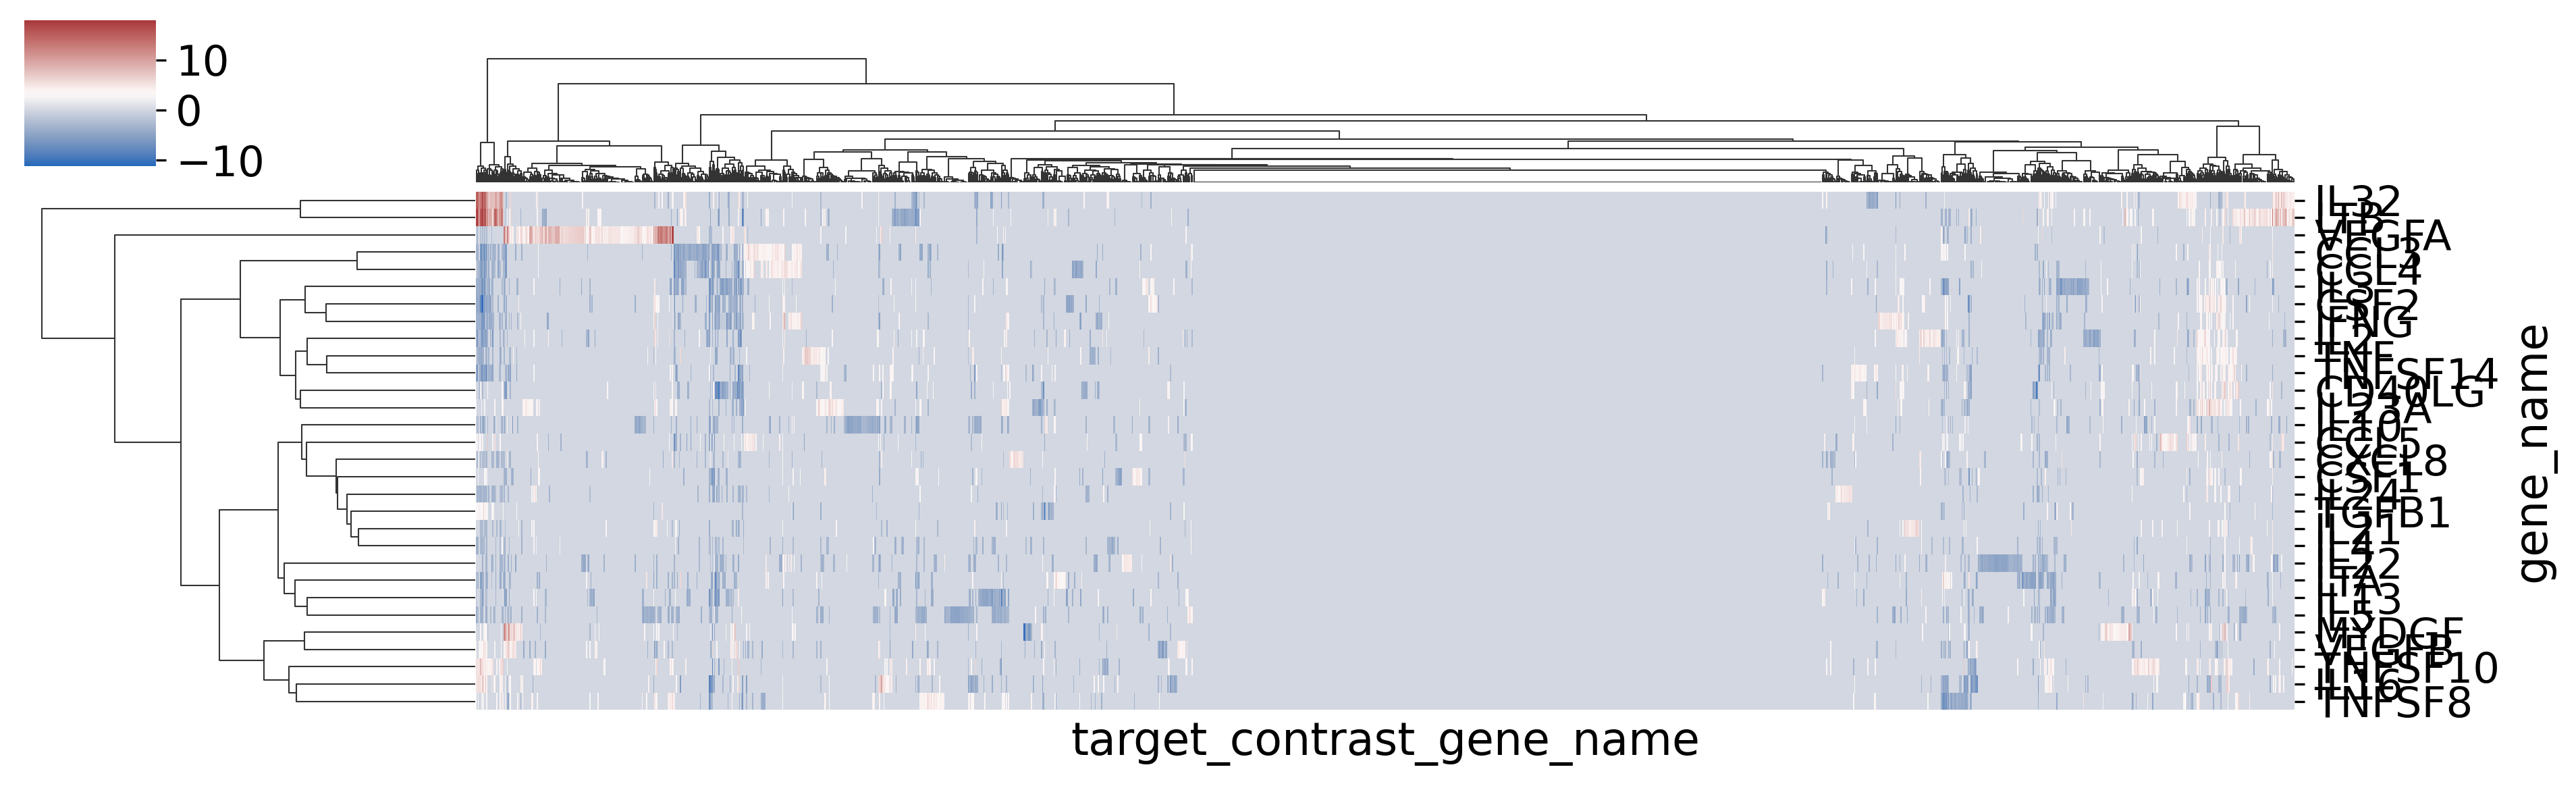

In [24]:
filtered_df = cytokines_de_df[cytokines_de_df['target_contrast_gene_name'].isin(unique_regulators)]
filtered_df['effect_size'] = filtered_df['zscore'].abs()
all_genes = filtered_df['gene_name'].unique()

# Show only significant effects
filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Create pivot tables with explicit index and columns to ensure same shape
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).fillna(0)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).fillna(0)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).fillna(0)

# Get clustered regulators order without plotting (Stim8hr clustering)
g = sns.clustermap(
    stim8hr_pl_df, 
    xticklabels=False, 
    yticklabels=True, 
    cmap=palettes['DE_effects_cmap'], 
    figsize=(13,4),
    method='ward'  # specify different linkage method as desired, e.g., 'average'
)
unique_regulators_order = stim8hr_pl_df.columns[g.dendrogram_col.reordered_ind].tolist()
all_genes_order = stim8hr_pl_df.index[g.dendrogram_row.reordered_ind].tolist()

# Create pivot tables with explicit index and columns to ensure same shape
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

Plot effects in Rest and Stim8hr

In [22]:
column_cluster_df[column_cluster_df['cluster'] == cl_glyco]

column_name  cluster
43         CDS2        3
44        TMED2        3
45        CDIPT        3
46       MRPL10        3
47         NPC2        3
..          ...      ...
184        CTU2        3
185        ELP4        3
186        ELOB        3
187       RTRAF        3
188         SSB        3

[146 rows x 2 columns]

In [ ]:
column_cluster_df[column_cluster_df['cluster'] == cl_tcr].column_name.tolist()
column_cluster_df[column_cluster_df['cluster'] == cl_saga].column_name.tolist()

['CD2',
 'MEAF6',
 'DAD1',
 'GET1',
 'RNF40',
 'TOMM20',
 'DARS1',
 'IL7R',
 'TFAP4',
 'ENO1',
 'FAM20B',
 'ADO',
 'UGDH',
 'VPS29',
 'DR1',
 'GNPNAT1',
 'GOLGA8A',
 'C1S',
 'FAM204A',
 'TSPAN9',
 'MCTS1',
 'PSMD4',
 'NUDCD3',
 'BCL3',
 'KLF2',
 'PIM1',
 'NAA25',
 'MYEF2',
 'MRPS5',
 'RC3H1',
 'TBC1D10B',
 'FMNL1',
 'PAQR8',
 'TSPAN4',
 'COQ4',
 'SEC22B',
 'NAA20',
 'PHF12',
 'GCN1',
 'RAP1A',
 'TSC1',
 'WAPL',
 'FOXK1',
 'WDR48',
 'LRRC56',
 'DOT1L',
 'FDX2',
 'FXN',
 'DIS3L',
 'BRPF1',
 'KMT2A',
 'DNAJC8',
 'BCL11B',
 'TNF',
 'PGAM1',
 'CLASRP',
 'MTHFD1',
 'FNBP4',
 'ORC4',
 'XRCC2',
 'KPNA1',
 'ITIH4',
 'MRPS11',
 'SZRD1',
 'MED23',
 'LIG1',
 'CAMSAP1',
 'BCL10',
 'HELT',
 'EML2',
 'CFAP20',
 'IMPDH2',
 'SYK',
 'CARMIL2',
 'SND1',
 'CD28',
 'MALT1',
 'TBX21',
 'CTBP1',
 'KDM1A',
 'EIF3H',
 'NSD1',
 'TAF4',
 'NELFA',
 'SLK',
 'MTRES1',
 'SPTLC2',
 'TET2',
 'CMAS',
 'EXOC7',
 'GP1BB',
 'MTOR',
 'COX10',
 'EAPP',
 'GAPDH',
 'ALDOA',
 'TGS1',
 'ATL2',
 'GSTP1',
 'UTP14C',
 'RCOR1',
 'C

old

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Create main figure with 2 columns: row colors + heatmap (no barplot)
y_labelsize = 12
fig = plt.figure(figsize=(9, 9))  # Narrower, just row color + heatmap
gs = fig.add_gridspec(1, 3, width_ratios=[0.05, 2, 0.07], wspace=0.01)  # Make space for colorbar in third col

# Define colors for consistent mapping
color_dict = {'Positive': '#3182bd', 'Negative': '#de2d26'}

# Prepare row annotations for culture condition
row_colors = [palettes['culture_condition'][condition] 
              for gene in all_genes_order 
              for condition in ['Rest', 'Stim8hr', 'Stim48hr']]

# Row color subplot
ax_colors = fig.add_subplot(gs[0,0])
condition_mapping = {condition: code for code, condition in enumerate(['Rest', 'Stim8hr', 'Stim48hr'])}
row_color_df = pd.DataFrame({
    'condition': [condition for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']],
    'code': [condition_mapping[condition] for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']]
})
condition_colors = list(palettes['culture_condition'].values())
cmap = ListedColormap(condition_colors)

sns.heatmap(row_color_df[['code']].values, 
            cmap=cmap, 
            cbar=False,  # We'll make a dedicated legend below
            yticklabels=row_names,
            xticklabels=['Condition'],
            linewidths=0.5, 
            linecolor='white', 
            ax=ax_colors)
ax_colors.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Create y-tick labels centered at k=1 (second row for each cytokine)
y_tick_locs = [i*3 + 1.5 for i in range(len(all_genes_order))]
y_tick_labels = list(all_genes_order)
ax_colors.set_yticks(y_tick_locs)
ax_colors.set_yticklabels(y_tick_labels)
ax_colors.set_ylabel('Measured cytokine-condition')


# Show color legend for the conditions: 
# Create colored patches for Rest, Stim8hr, Stim48hr
legend_patches = [
    mpatches.Patch(color=palettes['culture_condition']['Rest'], label='Rest'),
    mpatches.Patch(color=palettes['culture_condition']['Stim8hr'], label='Stim8hr'),
    mpatches.Patch(color=palettes['culture_condition']['Stim48hr'], label='Stim48hr')
]
# Position the legend just above the row color subplot
ax_colors.legend(handles=legend_patches, title='Condition', frameon=False, ncols=3,
                 bbox_to_anchor=(0.9, 1.02), loc='lower center', fontsize=10, title_fontsize=11, borderaxespad=0.)

# Combined condition heatmap with separate colorbar axis
ax1 = fig.add_subplot(gs[0,1])
cbar_ax = fig.add_subplot(gs[0,2])

heatmap = sns.heatmap(
    combined_pl_df, 
    center=0, 
    cmap=palettes['DE_effects_cmap'], 
    vmax=12, vmin=-12, 
    cbar=True, 
    cbar_ax=cbar_ax,
    cbar_kws={'label': 'DE effect\n(logFC z-score)', 'shrink': 0.85},
    xticklabels=False, 
    yticklabels=True, 
    ax=ax1, 
    rasterized=True
)
ax1.set_xlabel(f'Perturbed regulators (n = {combined_pl_df.shape[1]})')
ax1.set_ylabel('')

ax1.set_yticks([])

# Add horizontal lines between cytokines
for i in range(1, len(all_genes_order)):
    ax1.axhline(y=i*3, color='gray', linestyle='--', linewidth=0.5)

# Adjust layout
sns.despine()
plt.tight_layout()
plt.savefig('results/cytokine_regulators_overview.pdf', bbox_inches='tight', dpi=600)
plt.savefig('results/cytokine_regulators_overview.png', bbox_inches='tight', dpi=600)

In [82]:
# y_labelsize = 10
# fig = plt.figure(figsize=(5.5,10))  # Increase width to make space for legends
# gs = fig.add_gridspec(1, 2, width_ratios=[0.10, 0.9], wspace=0.01)

# # Define colors for consistent mapping
# color_dict = palettes['DE_effects_regulator_class']

# # --- Row color subplot
# ax_colors = fig.add_subplot(gs[0,0])
# condition_mapping = {condition: code for code, condition in enumerate(['Rest', 'Stim8hr', 'Stim48hr'])}
# row_color_df = pd.DataFrame({
#     'condition': [condition for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']],
#     'code': [condition_mapping[condition] for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']]
# })
# condition_colors = list(palettes['culture_condition'].values())
# cmap = ListedColormap(condition_colors)

# sns.heatmap(row_color_df[['code']].values,
#             cmap=cmap,
#             cbar=False,
#             yticklabels=row_names,
#             xticklabels=['Condition'],
#             linewidths=0.5,
#             linecolor='white',
#             ax=ax_colors)
# ax_colors.tick_params(axis='y', labelsize=y_labelsize)
# y_ticks = [f'{gene}' if k == 1 else ''
#            for i, gene in enumerate(all_genes_order) for k in range(3)]
# ax_colors.set_yticks(range(len(y_ticks))[1::3])
# ax_colors.set_yticklabels(y_ticks[1::3])
# ax_colors.set_xticklabels(ax_colors.get_xticklabels(), rotation=90)
# ax_colors.set_ylabel('Measured cytokine-condition')

# # --- Barplot subplot
# ax_bar = fig.add_subplot(gs[0,1])
# combined_reg_counts.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
#     kind='barh', stacked=True, ax=ax_bar, color=[color_dict['Positive'], color_dict['Negative']])
# ax_bar.set_ylabel('')
# ax_bar.set_xlabel('Number of regulators\n(significant DE 10% FDR)')
# ax_bar.set_xlim(0, 250)
# ax_bar.set_yticklabels([])
# ax_bar.set_yticks([])

# # Add legend for bar colors (regulator direction)
# from matplotlib.patches import Patch

# reg_legend = [Patch(facecolor=color_dict['Positive'], label='Positive regulator'),
#               Patch(facecolor=color_dict['Negative'], label='Negative regulator')]
# condition_legend = [Patch(facecolor=color, label=cond) for cond, color in zip(['Rest', 'Stim8hr', 'Stim48hr'], condition_colors)]

# # Move legends above plot
# from matplotlib.legend import Legend

# # Remove existing legends if any
# if ax_bar.get_legend() is not None:
#     ax_bar.get_legend().remove()

# # First legend: regulator direction
# leg1 = ax_bar.legend(handles=reg_legend,
#                     bbox_to_anchor=(0.28, 1.04), loc='lower center',
#                     frameon=False, title="Regulator\nDirection", ncol=1, fontsize=11, title_fontsize=12)

# # Second legend: condition colors
# leg2 = ax_bar.legend(handles=condition_legend,
#                     bbox_to_anchor=(0.72, 1.04), loc='lower center',
#                     frameon=False, title="Condition", ncol=1, fontsize=11, title_fontsize=12)

# # Add both legends
# ax_bar.add_artist(leg1)
# ax_bar.add_artist(leg2)

# # Add horizontal lines between cytokines in barplot
# for i in range(1, len(all_genes_order)):
#     ax_bar.axhline(y=(i*3) - 0.5, color='gray', linestyle='--', linewidth=0.5)

# sns.despine()
# fig.tight_layout(rect=[0, 0.08, 1, 1])  # Make space for bottom legends

# plt.savefig('results/cytokine_regulators_barplot.pdf', bbox_inches='tight', dpi=300)


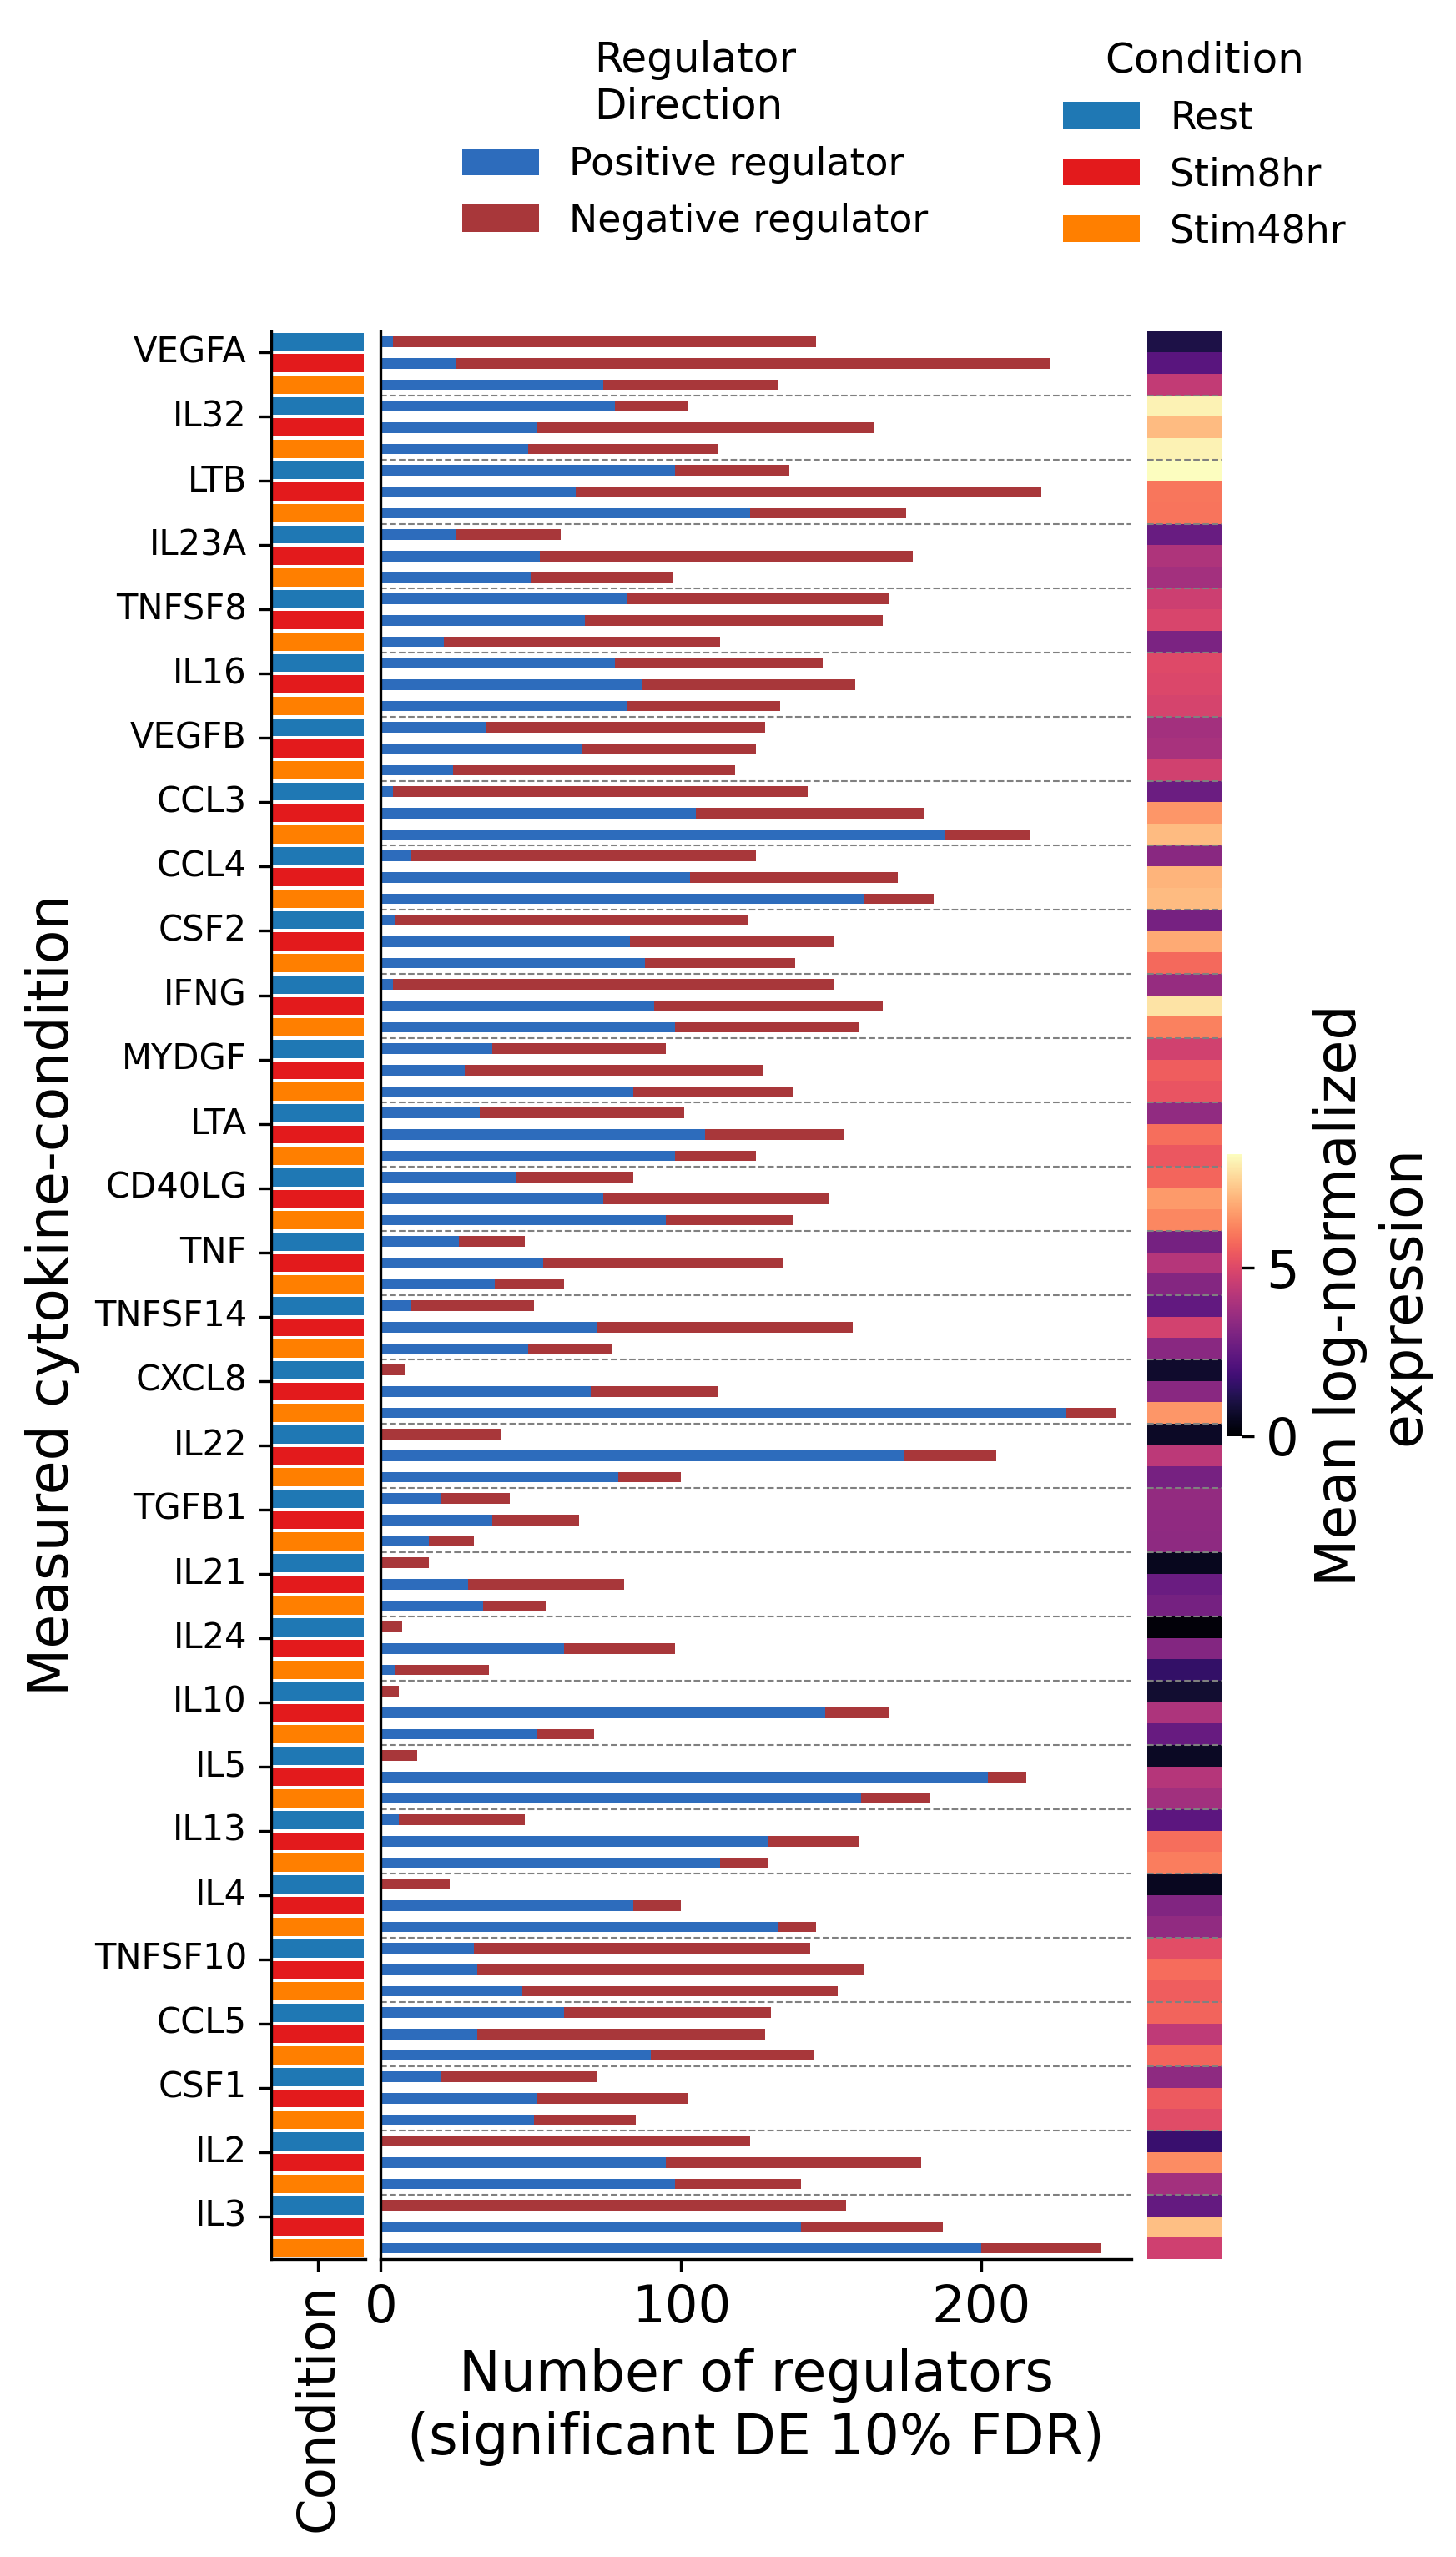

In [81]:
y_labelsize = 10
fig = plt.figure(figsize=(5,10))  # Expand width to fit 3 subplots side-by-side
gs = fig.add_gridspec(1, 3, width_ratios=[0.1, 0.80, 0.1], wspace=0.05)

# Define colors for consistent mapping
color_dict = palettes['DE_effects_regulator_class']

# --- Row color subplot (leftmost)
ax_colors = fig.add_subplot(gs[0,0])
condition_mapping = {condition: code for code, condition in enumerate(['Rest', 'Stim8hr', 'Stim48hr'])}
row_color_df = pd.DataFrame({
    'condition': [condition for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']],
    'code': [condition_mapping[condition] for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']]
})
condition_colors = list(palettes['culture_condition'].values())
cmap = ListedColormap(condition_colors)

sns.heatmap(row_color_df[['code']].values,
            cmap=cmap,
            cbar=False,
            yticklabels=row_names,
            xticklabels=['Condition'],
            linewidths=0.5,
            linecolor='white',
            ax=ax_colors)
ax_colors.tick_params(axis='y', labelsize=y_labelsize)
y_ticks = [f'{gene}' if k == 1 else ''
           for i, gene in enumerate(all_genes_order) for k in range(3)]
ax_colors.set_yticks(range(len(y_ticks))[1::3])
ax_colors.set_yticklabels(y_ticks[1::3])
ax_colors.set_xticklabels(ax_colors.get_xticklabels(), rotation=90)
ax_colors.set_ylabel('Measured cytokine-condition')

# --- Barplot subplot (center)
ax_bar = fig.add_subplot(gs[0,1])
combined_reg_counts.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax_bar, color=[color_dict['Positive'], color_dict['Negative']])
ax_bar.set_ylabel('')
ax_bar.set_xlabel('Number of regulators\n(significant DE 10% FDR)')
ax_bar.set_xlim(0, 250)
ax_bar.set_yticklabels([])
ax_bar.set_yticks([])

from matplotlib.patches import Patch

reg_legend = [Patch(facecolor=color_dict['Positive'], label='Positive regulator'),
              Patch(facecolor=color_dict['Negative'], label='Negative regulator')]
condition_legend = [Patch(facecolor=color, label=cond) for cond, color in zip(['Rest', 'Stim8hr', 'Stim48hr'], condition_colors)]

from matplotlib.legend import Legend

# Remove existing legends if any
if ax_bar.get_legend() is not None:
    ax_bar.get_legend().remove()

# Place both legends on the figure (not as artists) to guarantee visibility
# The axes coordinates for bbox_to_anchor need to be relative to the figure to avoid being cropped

# Regulator direction legend (left-aligned, above)
leg1 = fig.legend(
    handles=reg_legend,
    bbox_to_anchor=(0.25, 1.01),  # left above barplot, in figure coords
    bbox_transform=fig.transFigure,
    loc='upper left',
    frameon=False,
    title="Regulator\nDirection",
    ncol=1,
    fontsize=11,
    title_fontsize=12
)

# Condition legend (right-aligned, above)
leg2 = fig.legend(
    handles=condition_legend,
    bbox_to_anchor=(0.73, 1.01),  # right above barplot, in figure coords
    bbox_transform=fig.transFigure,
    loc='upper left',
    frameon=False,
    title="Condition",
    ncol=1,
    fontsize=11,
    title_fontsize=12
)

# Add horizontal lines between cytokines in barplot
for i in range(1, len(all_genes_order)):
    ax_bar.axhline(y=(i*3) - 0.5, color='gray', linestyle='--', linewidth=0.5)

sns.despine(fig=fig)
fig.tight_layout(rect=[0, 0.08, 1, 0.91])  # leave space at top for legends

# --- Heatmap for 3-condition expression, as third subplot (right)
# Build matrix where index = ['CYTOKINE_NAME [Rest]', 'CYTOKINE_NAME [Stim8hr]', ...], one column: mean expression
expr_long_rows = []
expr_long_values = []
row_labels = []

for gene in all_genes_order:
    for cond in ["Rest", "Stim8hr", "Stim48hr"]:
        expr_long_rows.append((gene, cond))
        expr_long_values.append(expr_matrix.loc[gene, cond] if gene in expr_matrix.index else np.nan)
        row_labels.append(f"{gene} [{cond}]")

expr_heatmap_matrix = pd.DataFrame({'Expression': np.log1p(expr_long_values)}, index=row_labels)

# Use same y axis as other axes, so match the number/order of rows.
ax_expr = fig.add_subplot(gs[0,2])
heatmap = sns.heatmap(
    expr_heatmap_matrix,
    cmap='magma', vmin=0, cbar=True,
    xticklabels=False, yticklabels=False,
    rasterized=True,
    ax=ax_expr,
    cbar_kws={"label": "Mean log-normalized\nexpression"}
)
ax_expr.set_xlabel('')
ax_expr.set_ylabel('')
ax_expr.set_yticks([])  # turn off y-ticks to keep tight visually

# Add separation lines between cytokines (horizontal)
for i in range(1, len(all_genes_order)):
    # Each cytokine has 3 rows
    ax_expr.axhline(y=i*3, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0.08, 1, 0.91])  # match space for top legends

plt.savefig('results/cytokine_regulators_barplot.pdf', bbox_inches='tight', dpi=600)
plt.savefig('results/cytokine_regulators_barplot.png', bbox_inches='tight', dpi=600)


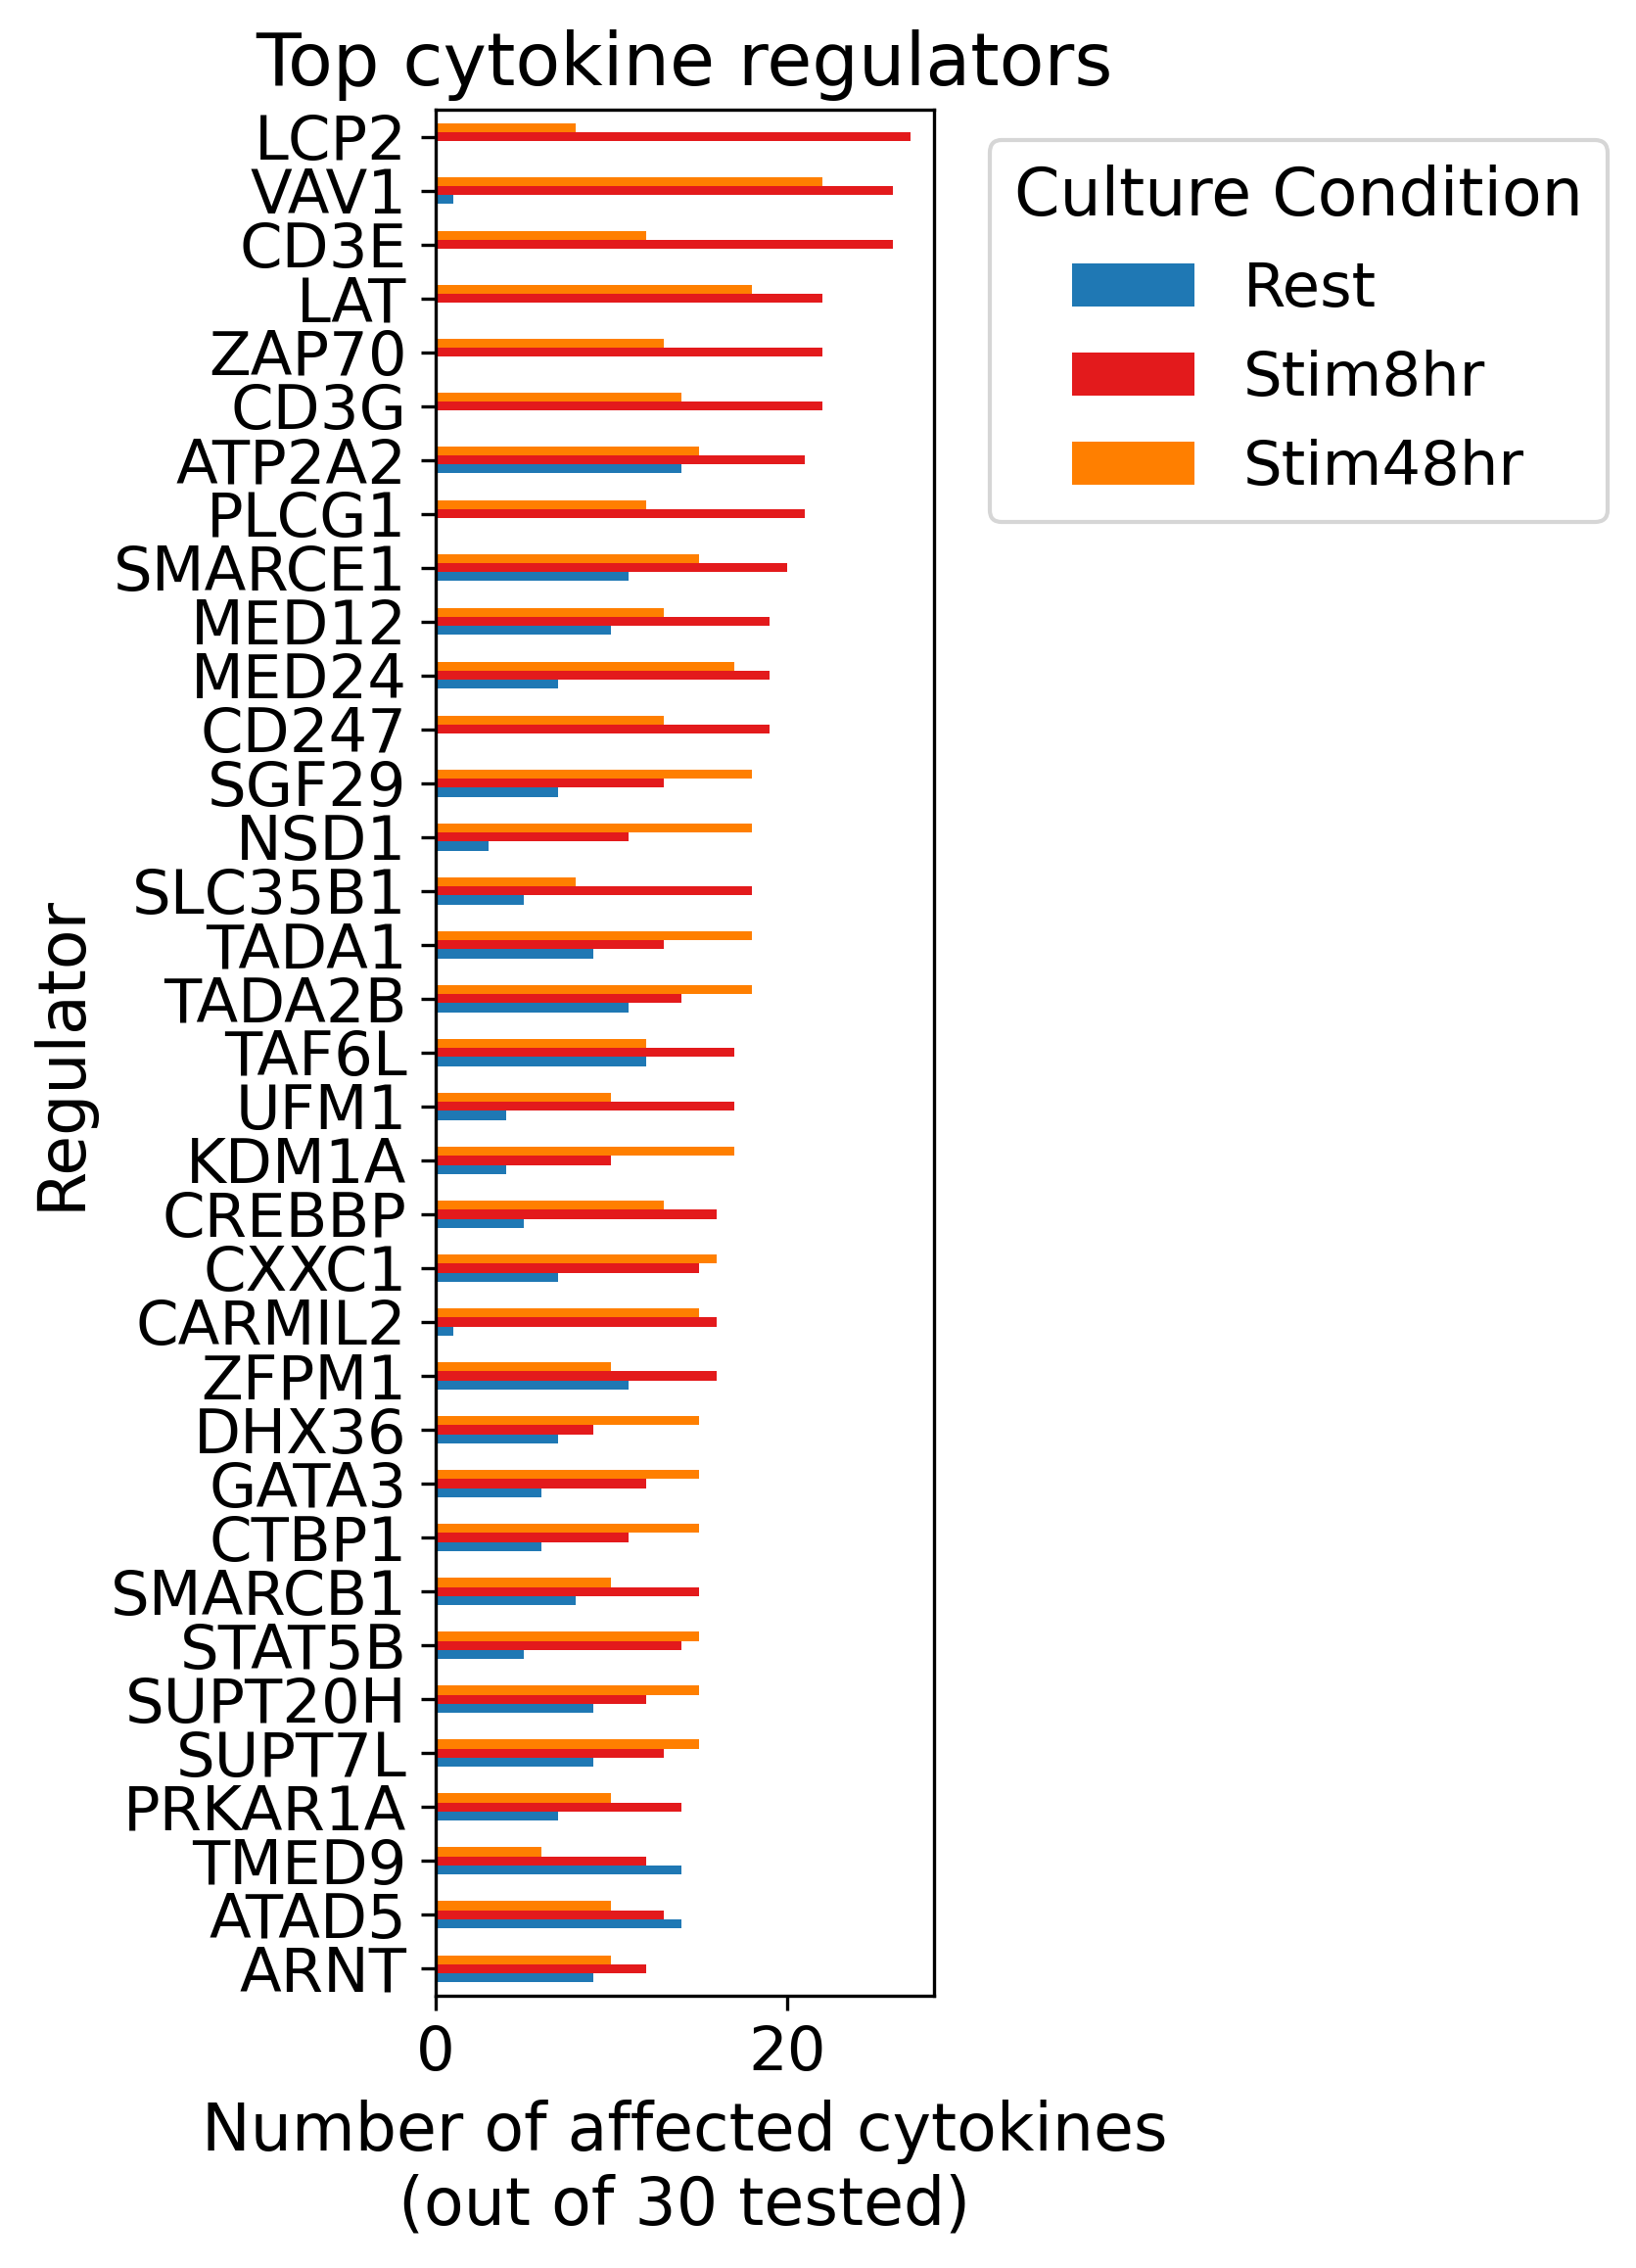

In [123]:
# Plot the number of significant findings for each unique regulator as a stacked bar plot
significant_counts = cytokines_de_df[cytokines_de_df.target_contrast_gene_name.isin(unique_regulators)].groupby(['target_contrast_gene_name', 'culture_condition'])['significant'].sum().unstack()
total_counts = significant_counts.sum(1)
total_counts = total_counts[total_counts > 30]
max_counts = significant_counts.loc[total_counts.index].max(1).sort_values()
significant_counts = significant_counts.loc[max_counts.index]

# Define color mapping for culture conditions
fig, ax = plt.subplots(figsize=(6, 8))
significant_counts.plot(kind='barh', stacked=False, color=[palettes['culture_condition'][col] for col in significant_counts.columns], ax=ax)
plt.ylabel('Regulator')
plt.xlabel('Number of affected cytokines\n(out of 30 tested)')
plt.title('Top cytokine regulators')
plt.legend(title='Culture Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/cytokine_regulators_top.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [126]:
n_top = 5

# Get top target conditions for each cytokine
top_target_conditions = []
cytokine_to_targets = {}
from tqdm import tqdm
for cytokine in tqdm(cytokines_de_df['gene_name'].unique()):
    # Get data for this cytokine
    cytokine_data = cytokines_de_df[cytokines_de_df['gene_name'] == cytokine]
    cytokine_data = cytokine_data[cytokine_data['significant']]
    
    # Get top 2 positive effects by zscore
    top_pos = cytokine_data.nlargest(n_top, 'zscore')['target_condition'].unique()
    
    # Get top 2 negative effects by zscore
    top_neg = cytokine_data.nsmallest(n_top, 'zscore')['target_condition'].unique()
    
    # Store in dictionary
    cytokine_to_targets[cytokine] = list(top_pos) + list(top_neg)
    
    # Add to overall list
    top_target_conditions.extend(top_pos)
    top_target_conditions.extend(top_neg)

# Remove duplicates while preserving order
top_target_conditions_ls = list(dict.fromkeys(top_target_conditions))
top_targets = [x.split('_')[0] for x in top_target_conditions_ls]
cytokine_to_targets = {k:[x.split('_')[0] for x in v] for k,v in cytokine_to_targets.items()}

100%|██████████| 30/30 [00:01<00:00, 21.30it/s]


In [127]:
# Get which target-cytokine trans effects are discovered in each condition
# First get the discovery condition matrix as before
discovery_condition = cytokines_de_df[cytokines_de_df['target_contrast_gene_name'].isin(top_targets)].pivot(index=['target_contrast_gene_name', 'gene_name'], columns='culture_condition', values='significant').fillna(False).reset_index()

# For each target, calculate what fraction of its total discoveries occur in each condition
discovery_counts_by_target = discovery_condition.groupby('target_contrast_gene_name')[['Rest', 'Stim8hr', 'Stim48hr']].sum()
discovery_fractions_by_target = discovery_counts_by_target.div(discovery_counts_by_target.sum(axis=1), axis=0).reset_index()

# For each cytokine, calculate what fraction of its regulators are discovered in each condition
discovery_counts_by_cytokine = discovery_condition.groupby('gene_name')[['Rest', 'Stim8hr', 'Stim48hr']].sum()
discovery_fractions_by_cytokine = discovery_counts_by_cytokine.div(discovery_counts_by_cytokine.sum(axis=1), axis=0).reset_index()

# Rename for clarity since we'll use both
discovery_fractions = discovery_fractions_by_target

# Filter data for top conditions and create pivot table
filtered_df = cytokines_de_df[cytokines_de_df['target_condition'].isin(top_target_conditions_ls)]
filtered_df['effect_size'] = filtered_df['zscore'].abs()

# For each target-gene pair, keep only the condition with strongest effect
filtered_df = filtered_df[filtered_df['significant']]
filtered_df = filtered_df.loc[filtered_df.groupby(['target_contrast_gene_name', 'gene_name'], observed=True)['effect_size'].idxmax()]
filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Create pivot table with strongest effect across conditions
pl_df = filtered_df.pivot(index='gene_name', columns=['target_contrast_gene_name'], values='zscore').fillna(0)
all_genes = pl_df.index
all_targets = [col.split('_')[0] for col in pl_df.columns]

# Create matched pivot table for each condition
filtered_df = cytokines_de_df[(cytokines_de_df['gene_name'].isin(all_genes)) & (cytokines_de_df['target_contrast_gene_name'].isin(all_targets))]
filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Create pivot tables with explicit index and columns to ensure same shape
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes, columns=all_targets).fillna(0)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes, columns=all_targets).fillna(0)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes, columns=all_targets).fillna(0)

# Verify shapes match
assert rest_pl_df.shape == stim8hr_pl_df.shape == stim48hr_pl_df.shape == pl_df.shape

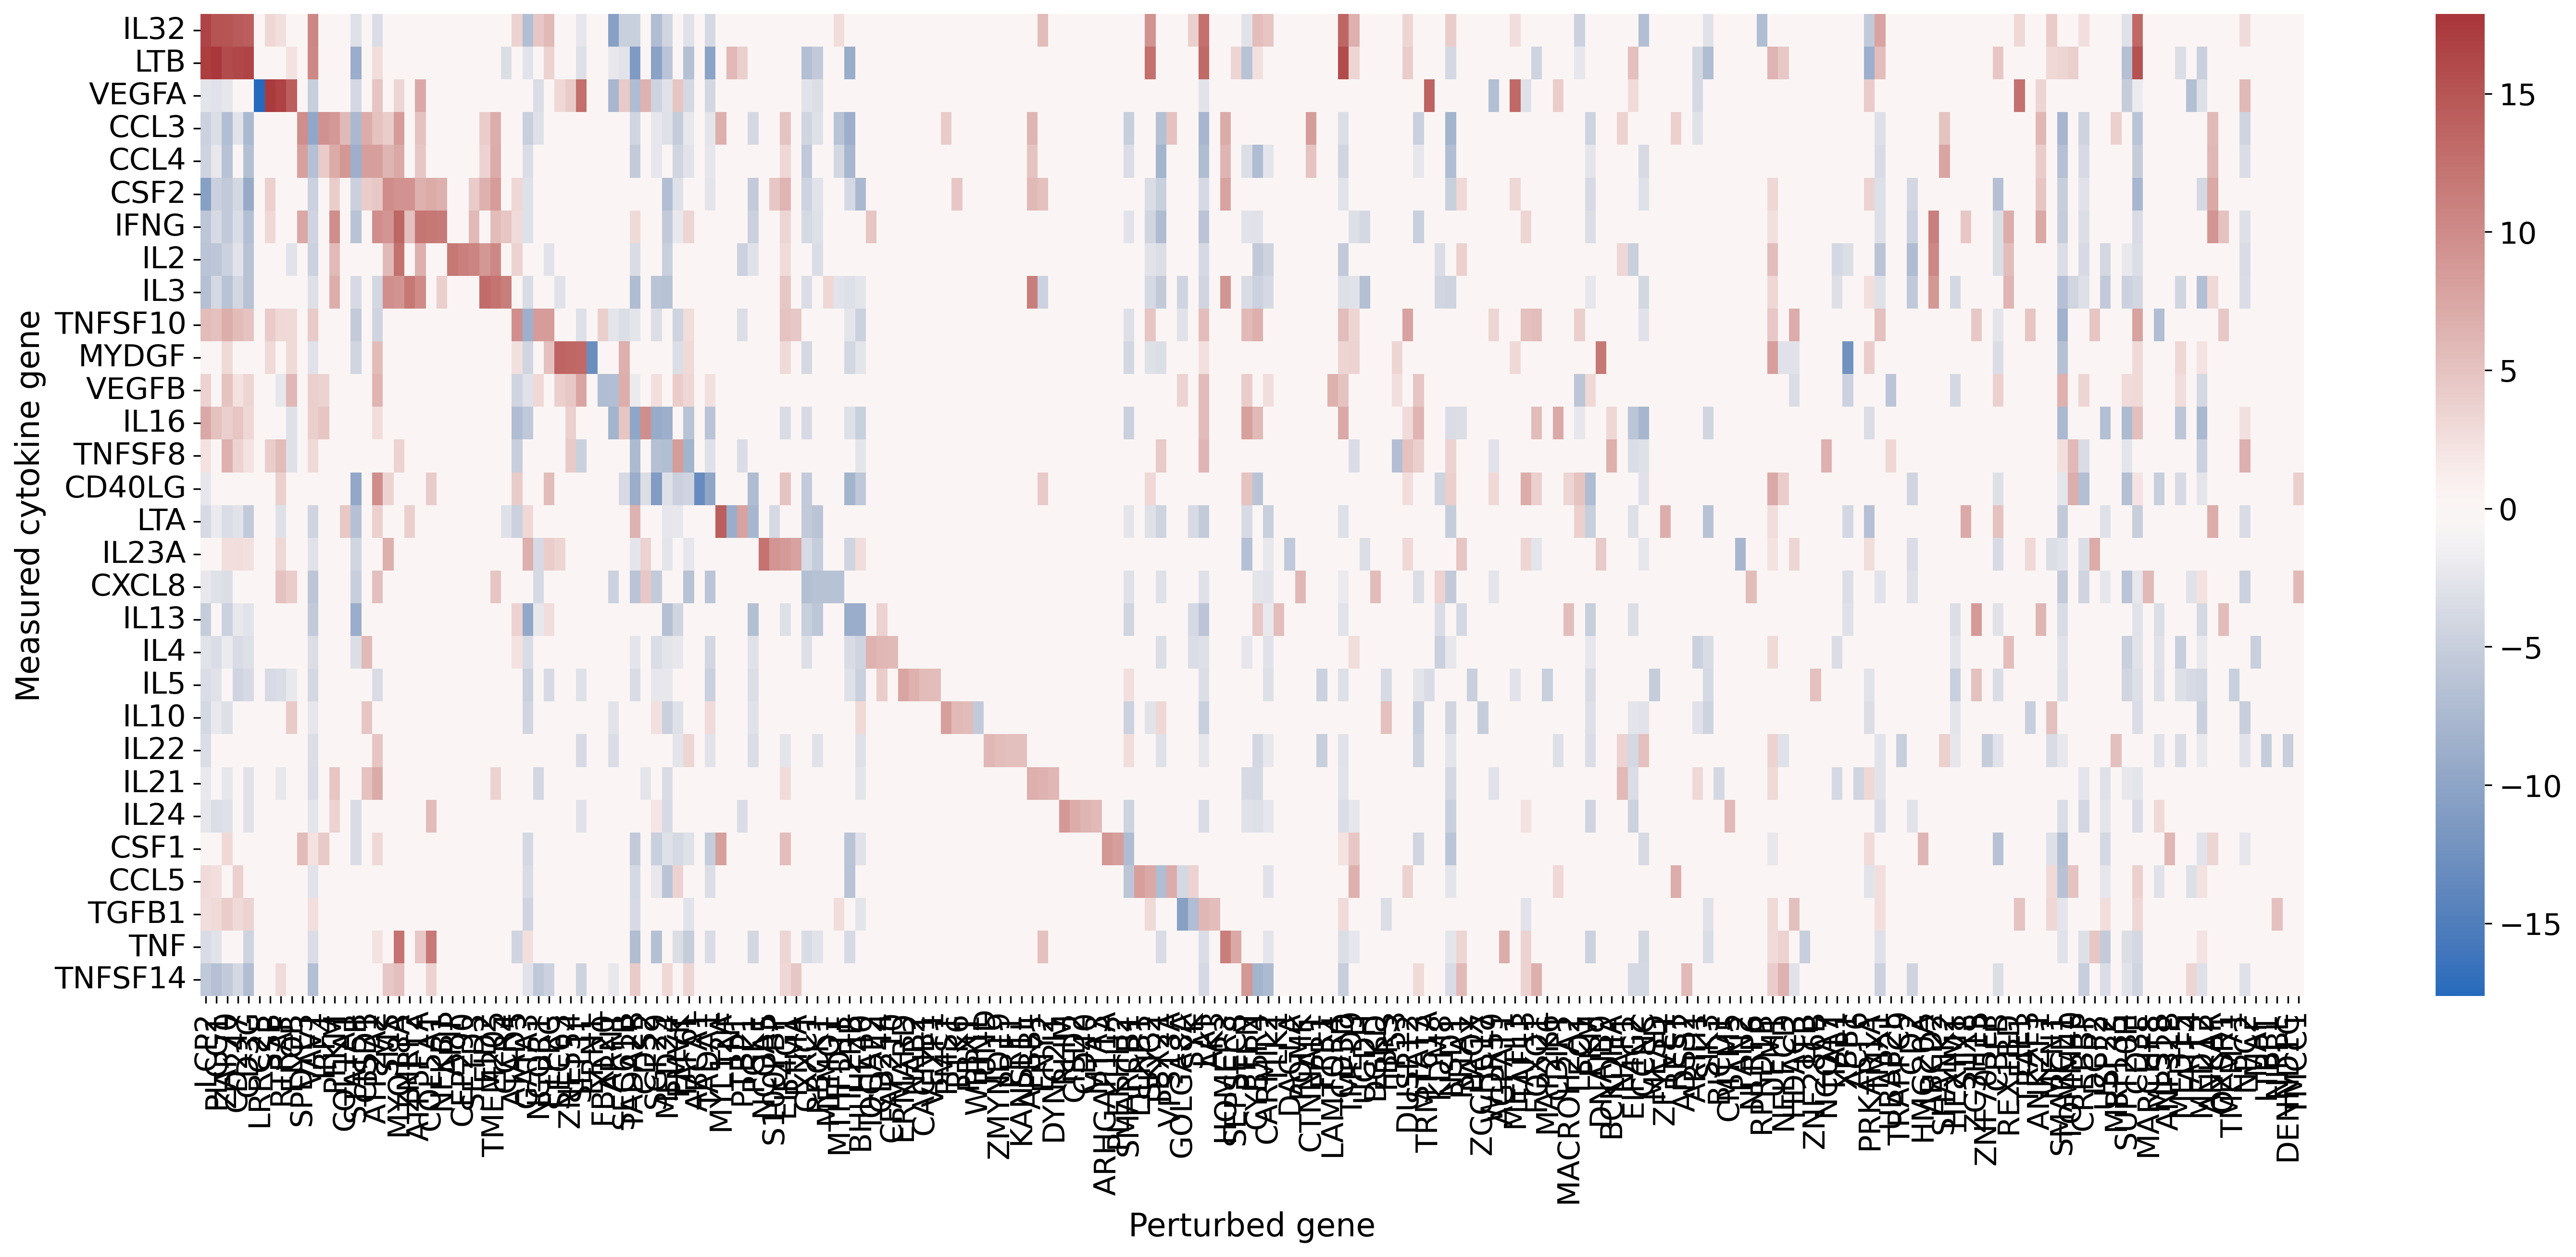

In [128]:

# Cluster rows (cytokines) by similarity
from scipy.cluster.hierarchy import linkage, leaves_list
row_linkage = linkage(pl_df, method='average')
row_order = leaves_list(row_linkage)
pl_df = pl_df.iloc[row_order]

# For each cytokine, find the top 6 conditions with strongest absolute effects
strongest_conditions = []
for cytokine in pl_df.index:
    # Get absolute values and sort to find top 6 conditions
    abs_effects = pl_df.loc[cytokine].abs()
    top_6_conds = abs_effects.nlargest(4).index.tolist()
    strongest_conditions.extend(top_6_conds)

ordered_cols = list(dict.fromkeys(strongest_conditions))
remaining_cols = set(pl_df.columns) - set(ordered_cols)
ordered_cols.extend(remaining_cols)

# Reorder the dataframe columns and rename to just target names
pl_df = pl_df[ordered_cols]
rest_pl_df = rest_pl_df.loc[pl_df.index, ordered_cols]
stim8hr_pl_df = stim8hr_pl_df.loc[pl_df.index, ordered_cols]
stim48hr_pl_df = stim48hr_pl_df.loc[pl_df.index, ordered_cols]

assert pl_df.columns.is_unique

discovery_frac_pl_df = discovery_fractions.dropna().set_index('target_contrast_gene_name').loc[pl_df.columns]
# Bottom subplot - heatmap
plt.figure(figsize=(20,9))
sns.heatmap(pl_df, center=0, cmap=palettes['DE_effects_cmap'], cbar_kws={'location': 'right'}, xticklabels=True)
plt.xlabel('Perturbed gene')
plt.ylabel('Measured cytokine gene')
plt.tight_layout()


In [129]:
filtered_df = cytokines_de_df[(cytokines_de_df['gene_name'].isin(all_genes)) & (cytokines_de_df['target_contrast_gene_name'].isin(all_targets))]
# filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Filter targets for each cytokine
filtered_rows = []
for gene_name in filtered_df['gene'].unique():
    if gene_name in cytokine_to_targets:
        valid_targets = cytokine_to_targets[gene_name]
        gene_df = filtered_df[
            (filtered_df['gene'] == gene_name) & 
            (filtered_df['target_contrast_gene_name'].isin(valid_targets))
        ]
        filtered_rows.append(gene_df)

filtered_df = pd.concat(filtered_rows, ignore_index=True)

# Compute mean zscore across conditions for each cytokine-target pair
mean_zscores = filtered_df.groupby(['gene', 'target_contrast_gene_name'])['zscore'].mean().reset_index()

plot_df_pos = pd.merge(mean_zscores[mean_zscores['zscore'] > 0][['gene', 'target_contrast_gene_name']], filtered_df, how='left')
plot_df_neg = pd.merge(mean_zscores[mean_zscores['zscore'] < 0][['gene', 'target_contrast_gene_name']], filtered_df, how='left')

In [135]:
def create_cytokine_regulation_plot(plot_df, title, ax=None, right_label=False, gene_label_fontsize=14, offset_scale = 0.5, ylabel_fontsize=10, spacing_between_cytokines = 0.5, row_order=None):
    # If no ax is provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 20))
    
    # Create a mapping from gene-target pair to a numeric y-position with spacing between cytokines
    gene_target_pairs = []
    y_positions = []
    y_labels = []
    y_pos = 0
    prev_gene = None

    # Use row_order to sort the genes
    sorted_plot_df = plot_df.copy()
    sorted_plot_df['gene_order'] = sorted_plot_df['gene'].map({gene: idx for idx, gene in enumerate(row_order)})
    sorted_plot_df = sorted_plot_df.sort_values(['gene_order', 'gene', 'target_contrast_gene_name'])

    for idx, row in sorted_plot_df.iterrows():
        gene = row['gene']
        target = row['target_contrast_gene_name']
        pair = f"{gene} - {target}"
        
        # Add extra spacing between different cytokines
        if prev_gene is not None and gene != prev_gene:
            y_pos += spacing_between_cytokines  # Add spacing between cytokines
        
        if pair not in gene_target_pairs:
            gene_target_pairs.append(pair)
            y_positions.append(y_pos)
            y_labels.append(target)  # Only show target name on y-axis
            y_pos += 1
        
        prev_gene = gene

    # Map the pairs to their positions - optimized with vectorized operation
    pair_to_pos = dict(zip(gene_target_pairs, y_positions))
    sorted_plot_df['gene_target_pair'] = sorted_plot_df['gene'].astype(str) + ' - ' + sorted_plot_df['target_contrast_gene_name'].astype(str)
    sorted_plot_df['y_position'] = sorted_plot_df['gene_target_pair'].map(pair_to_pos)

    # Create scatter plot using numeric y positions, masking out zscore=0
    plot_df_nonzero = sorted_plot_df[sorted_plot_df['zscore'] != 0]
    
    # Separate significant and non-significant points
    significant_points = plot_df_nonzero[plot_df_nonzero['significant']]
    non_significant_points = plot_df_nonzero[~plot_df_nonzero['significant']]
    
    # Add background color for each cytokine group
    unique_genes = sorted_plot_df['gene'].unique()
    for i, gene in enumerate(unique_genes):
        gene_pairs = [p for p in gene_target_pairs if p.startswith(gene + ' - ')]
        gene_y_positions = [pair_to_pos[p] for p in gene_pairs]
        
        # Alternate background colors
        bg_color = 'white' if i % 2 == 0 else 'lightgray'
        
        ax.axhspan(min(gene_y_positions)-0.5, max(gene_y_positions)+0.5, 
                   facecolor=bg_color, alpha=0.3, zorder=-1)

    # Plot non-significant points without outline
    sns.scatterplot(data=non_significant_points,
                    y='y_position', 
                    x='zscore',
                    hue='culture_condition', 
                    palette=palettes['culture_condition'],
                    ax=ax,
                    s=80,
                    alpha=0.6,
                    edgecolor='none'
                    )
    
    # Plot significant points with black outline
    sns.scatterplot(data=significant_points,
                    y='y_position', 
                    x='zscore',
                    hue='culture_condition', 
                    palette=palettes['culture_condition'],
                    ax=ax,
                    s=80,
                    edgecolor='black',
                    linewidth=1
                    )

    # Set y-axis ticks and labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontsize=ylabel_fontsize)
    ax.set_ylabel('')

    # Add cytokine labels to the left of the y-axis
    # Find the position of each cytokine group
    prev_gene = None
    gene_positions = []
    gene_names = []

    for pair, pos in zip(gene_target_pairs, y_positions):
        gene = pair.split(' - ')[0]
        if gene != prev_gene:
            gene_positions.append(pos)
            gene_names.append(gene)
            prev_gene = gene

    # Calculate the middle position for each cytokine group
    gene_label_positions = []
    for i, gene in enumerate(gene_names):
        # Find all positions for this gene
        gene_pairs = [p for p in gene_target_pairs if p.startswith(gene + ' - ')]
        gene_y_positions = [pair_to_pos[p] for p in gene_pairs]
        # Calculate middle position
        mid_pos = (min(gene_y_positions) + max(gene_y_positions)) / 2
        gene_label_positions.append(mid_pos)

    # Add text labels for cytokines to the left
    xlim = ax.get_xlim()
    x_offset = xlim[0] - (xlim[1] - xlim[0]) * offset_scale  # Increased white space on the left
    if right_label:
        ax.yaxis.tick_right()  # Move y-axis ticks to the right side
        ax.yaxis.set_label_position('right')  # Move y-axis label to the right
        
    else:
        for gene, pos in zip(gene_names, gene_label_positions):
            ax.text(x_offset, pos, gene, 
                    fontsize=gene_label_fontsize, fontweight='bold', 
                    ha='center', va='center')

    ax.axvline(x=0, color='grey', ls=':')
    ax.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.5)
    sns.despine()

    # Adjust plot margins to make room for cytokine labels
    plt.subplots_adjust(left=0.2)  # Increased left margin
    ax.set_xlabel('Z-score')
    ax.set_title(title, fontsize=12, pad=10)

    plt.tight_layout()

# # Create plots for positive and negative regulators
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 18), gridspec_kw={'width_ratios': [1,1], 'wspace': 0.6})  # Increased figure width and added whitespace between plots
# create_cytokine_regulation_plot(plot_df_pos, 'Negative Regulators of Cytokines', ax=ax2)
# # plt.subplots_adjust(left=0.4)  # Increased margin
# create_cytokine_regulation_plot(plot_df_neg, 'Positive Regulators of Cytokines', ax=ax1, right_label=True)
# # plt.subplots_adjust(right=0.4)  # Increased margin
# plt.tight_layout()

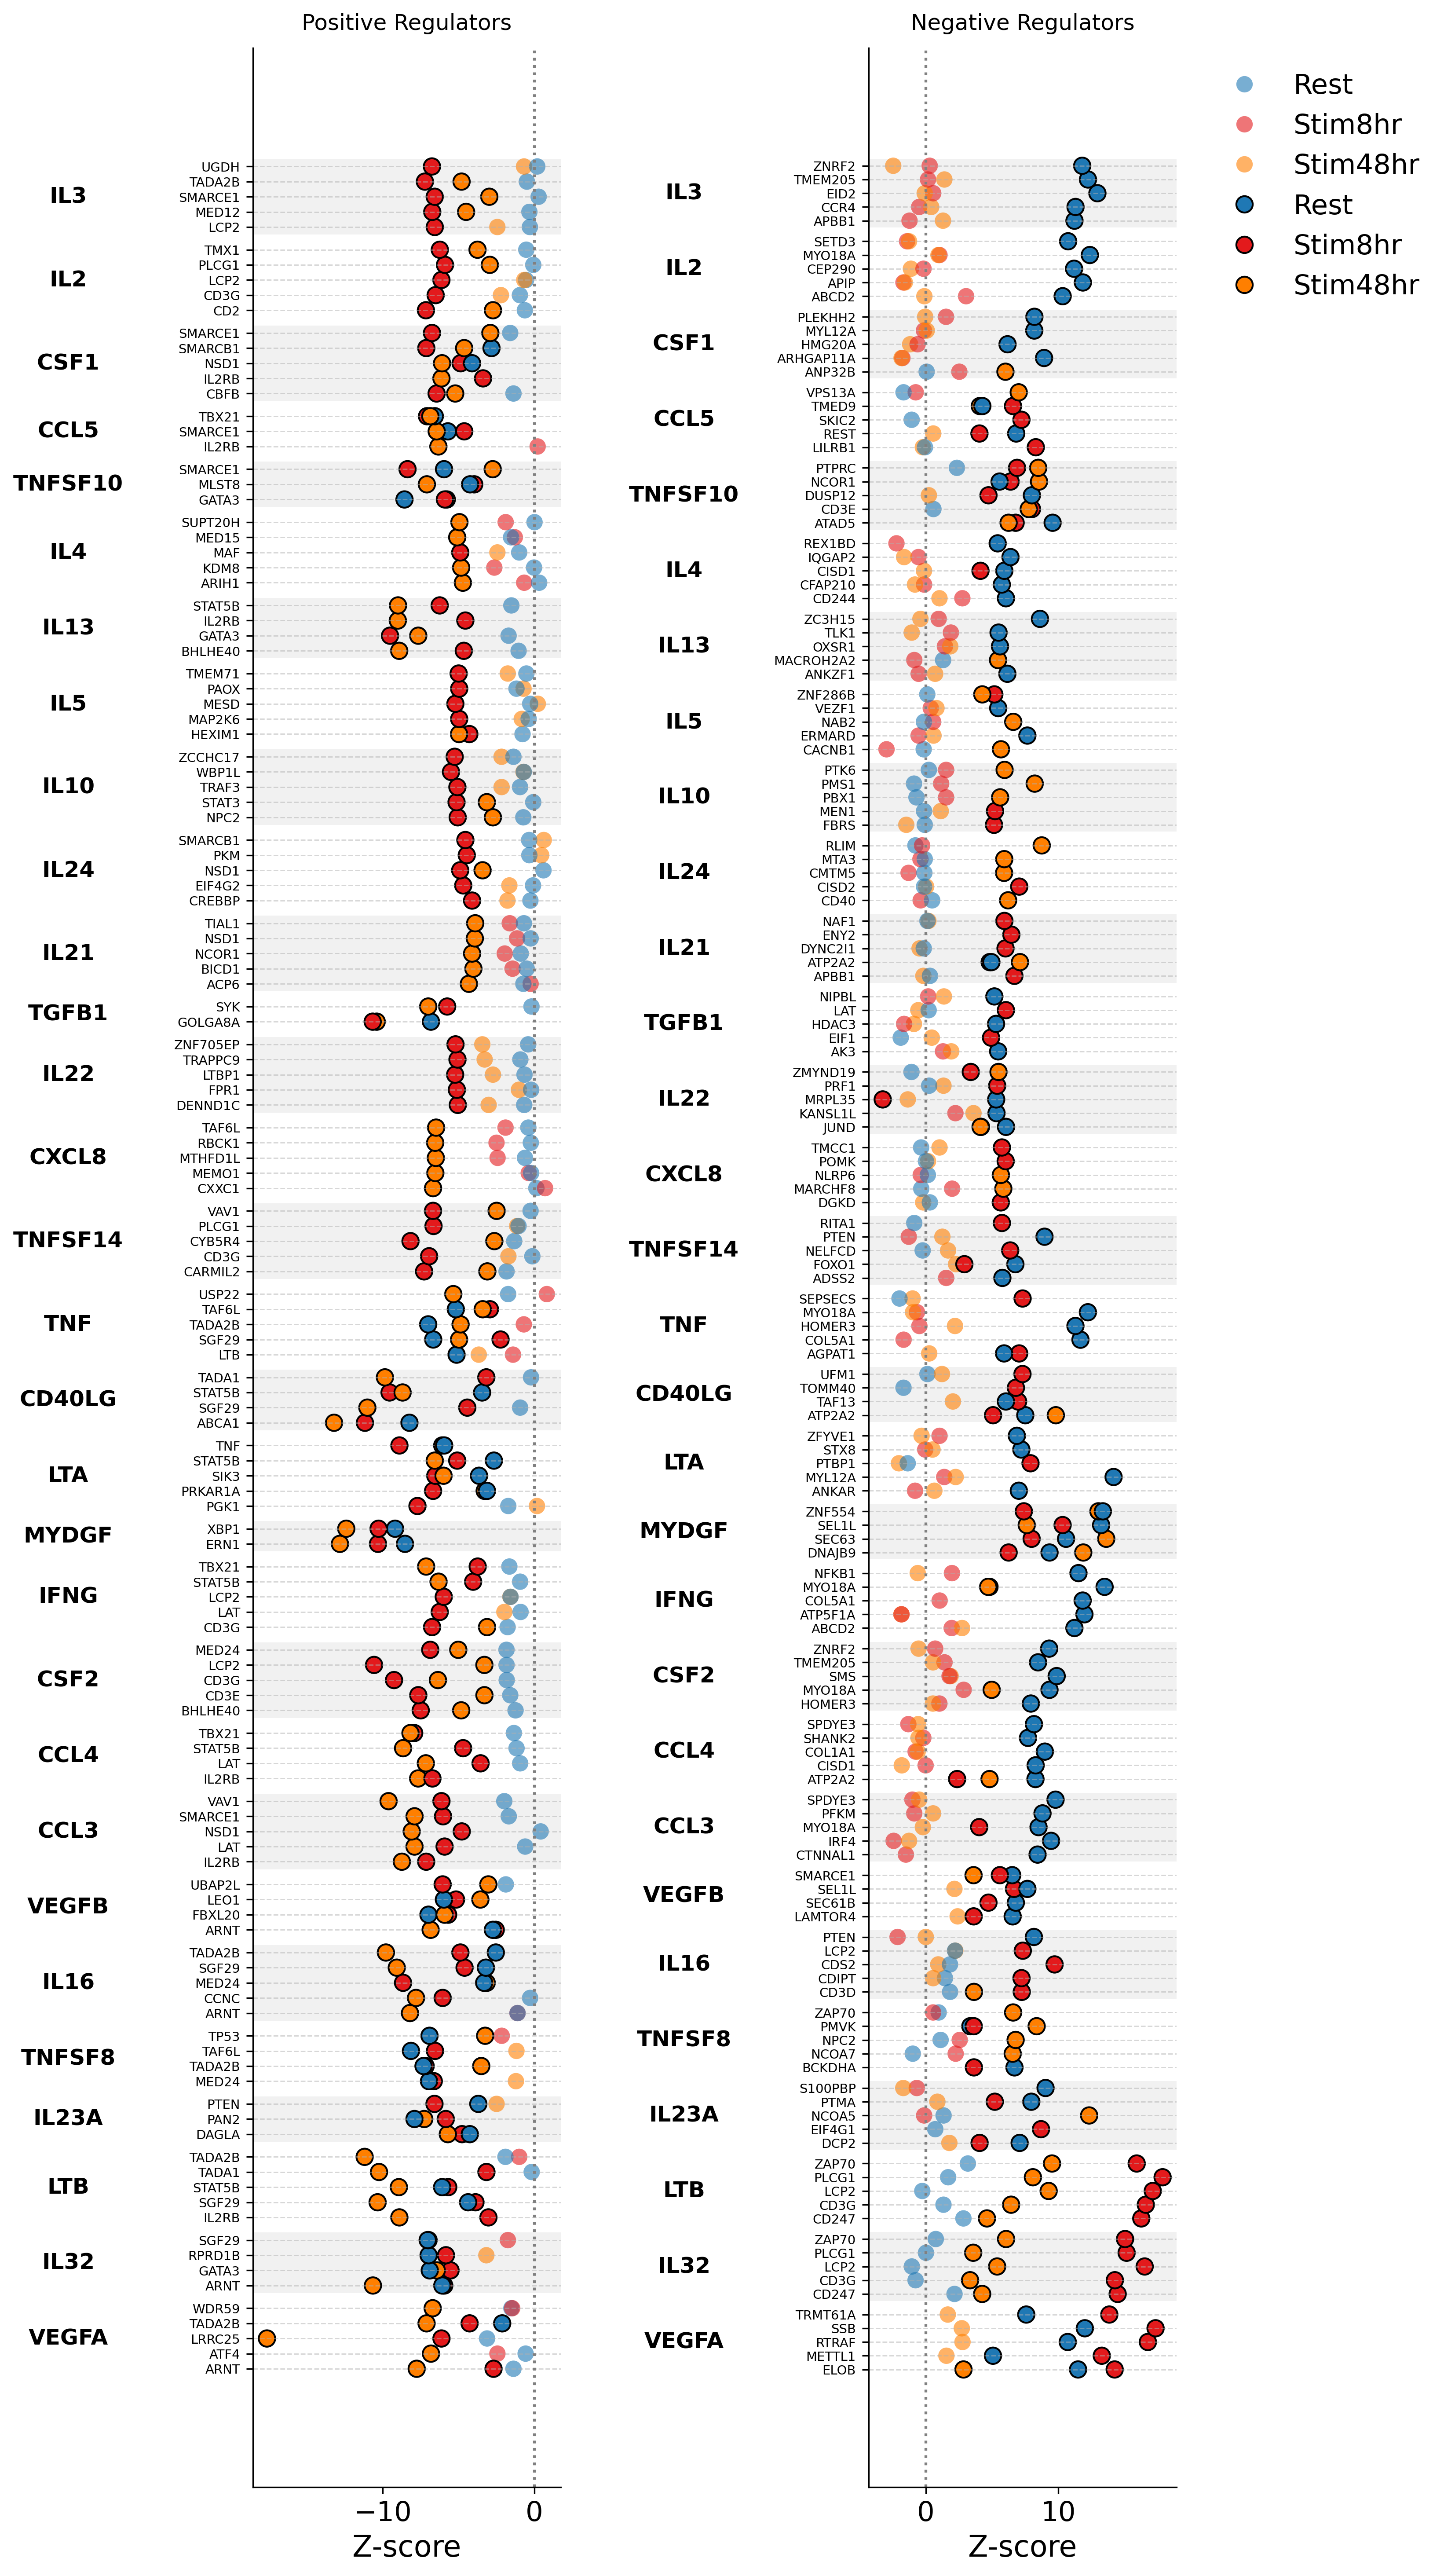

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 24), gridspec_kw={'wspace': 1.0})  # Increased figure width and added whitespace between plots
create_cytokine_regulation_plot(plot_df_neg.sort_values('gene_name'), 'Positive Regulators', ax=ax1, offset_scale = 0.6, row_order=all_genes_order,ylabel_fontsize=7, gene_label_fontsize=12)
create_cytokine_regulation_plot(plot_df_pos.sort_values('gene_name'), 'Negative Regulators', ax=ax2, offset_scale = 0.6, row_order=all_genes_order,ylabel_fontsize=7, gene_label_fontsize=12)

ax1.legend([], frameon=False)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.savefig('results/cytokine_regulators_all.pdf', bbox_inches='tight', dpi=600)


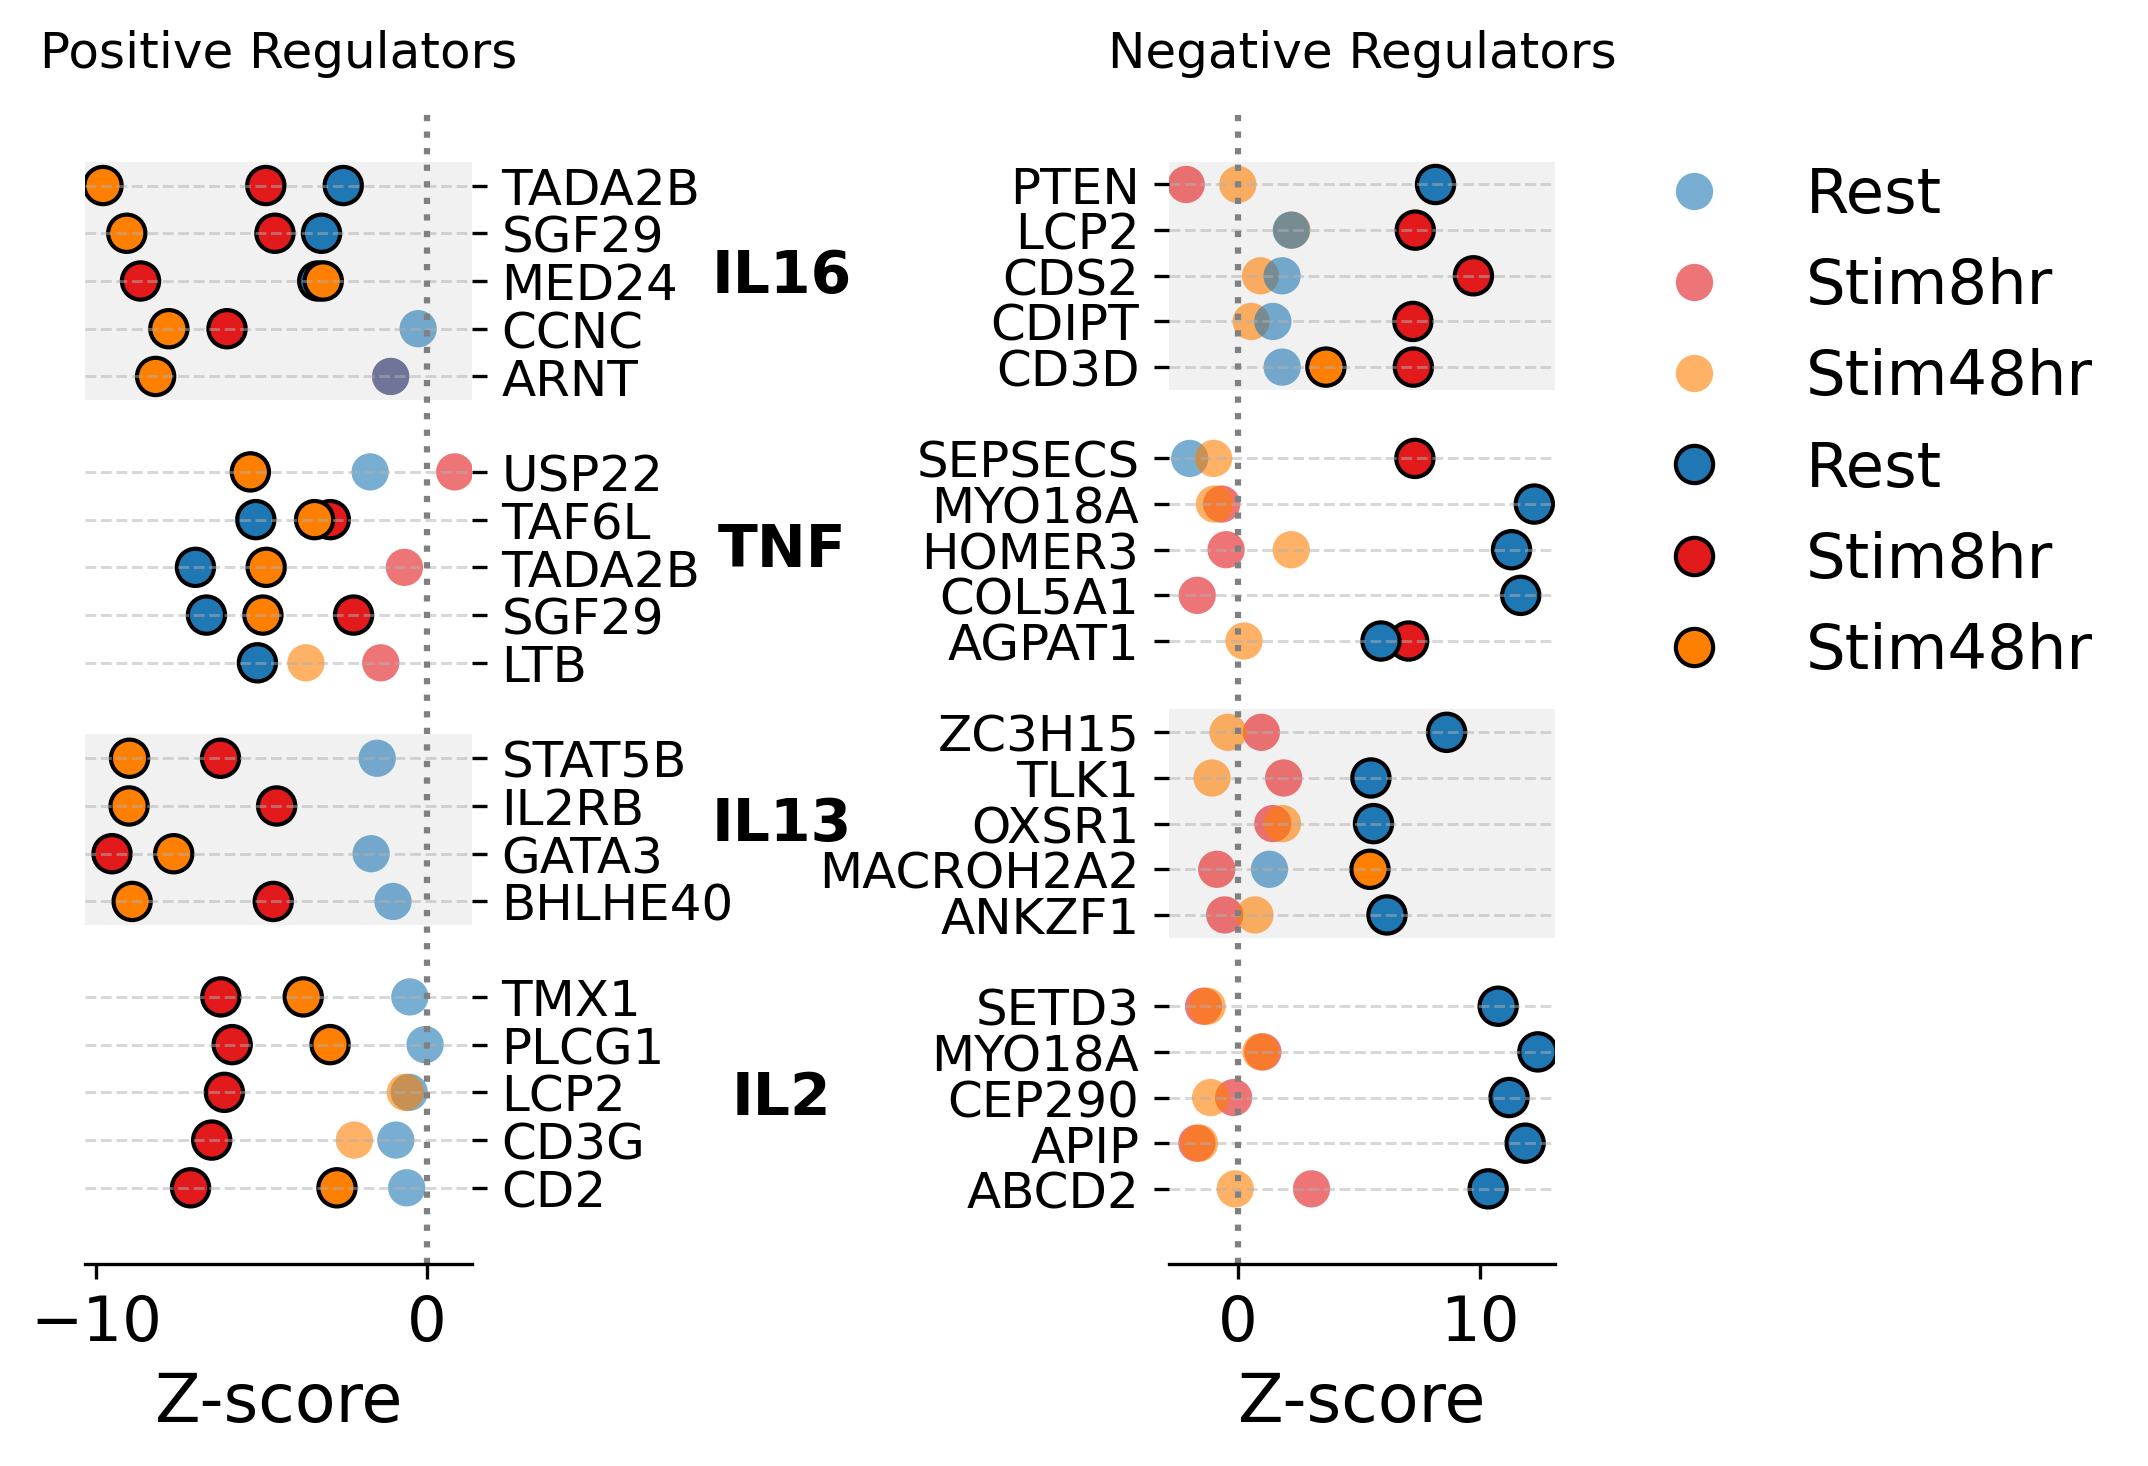

In [ ]:
pl_cytokines = ['IL2', 'IL3', 'IL13', 'TNF', 'IL16']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5), gridspec_kw={'wspace': 1.8})  # Increased figure width and added whitespace between plots
create_cytokine_regulation_plot(plot_df_neg[plot_df_neg['gene_name'].isin(pl_cytokines)].sort_values('gene_name'), 'Positive Regulators', ax=ax1, right_label=True, ylabel_fontsize=12, row_order=pl_cytokines, spacing_between_cytokines = 1.0)
create_cytokine_regulation_plot(plot_df_pos[plot_df_pos['gene_name'].isin(pl_cytokines)].sort_values('gene_name'), 'Negative Regulators', ax=ax2, offset_scale = 1.0, ylabel_fontsize=12, row_order=pl_cytokines, spacing_between_cytokines = 1.0)

# Remove left and right spines ("plot borders") for both axes
for ax in (ax1, ax2):
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax1.legend([], frameon=False)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.savefig('results/cytokine_regulators_example.pdf', bbox_inches='tight', dpi=600)


<Axes: xlabel='zscore', ylabel='culture_condition'>

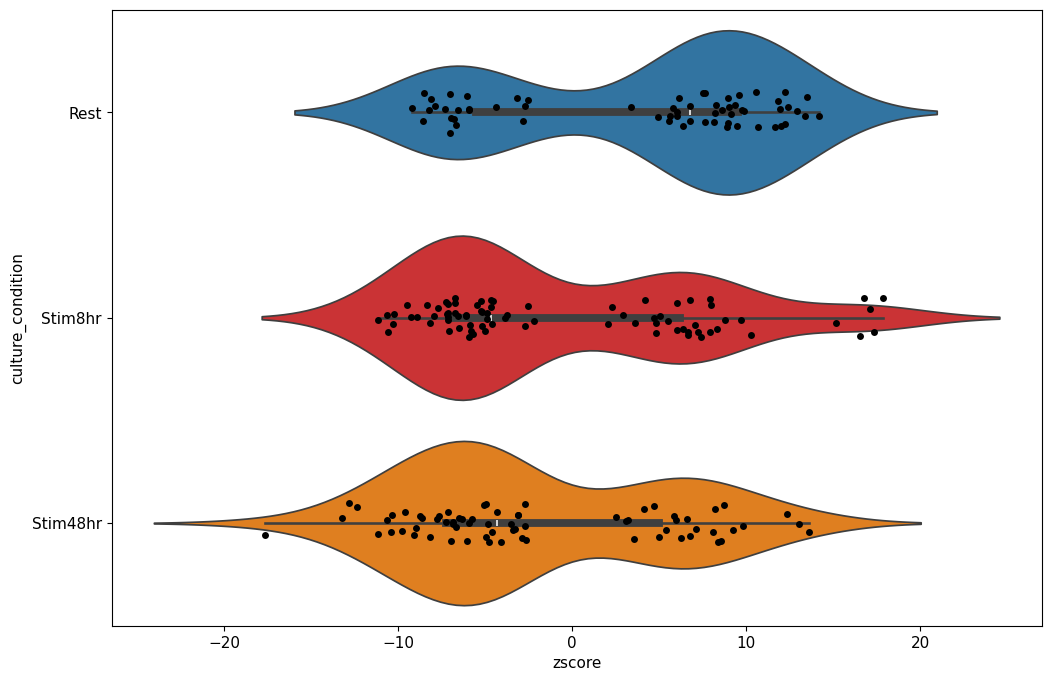

In [95]:

sns.violinplot(data=plot_df, x='zscore', y='culture_condition',hue='culture_condition', palette=palettes['culture_condition'])
sns.stripplot(data=plot_df, x='zscore', y='culture_condition', color='black')

# sns.violinplot(data=plot_df_pos, x='zscore', y='culture_condition',hue='culture_condition', palette=palettes['culture_condition'])
# sns.stripplot(data=plot_df_pos, x='zscore', y='culture_condition',hue='culture_condition', palette=palettes['culture_condition'])

## Upstream / downstream networks

In [125]:
upstream_regulators = ['ATP2A2', 'CYB5R4'] 
target_cytokine = ['IL21']
# upstream_regulators = ['KDM1A','MED24', "MEN1", 'ELOB']
# target_cytokine = ['IL10']
regulators_cytokines_de_df = get_DE_results_long(adata_de, targets = upstream_regulators)
regulators_cytokines_de_df = regulators_cytokines_de_df[regulators_cytokines_de_df['culture_condition'] == 'Stim8hr']

downstream2regulators = regulators_cytokines_de_df[regulators_cytokines_de_df['significant']]['gene']
downstream2regulators_cytokines_de_df = get_DE_results_long(adata_de, targets = downstream2regulators, genes=target_cytokine)
downstream2regulators_cytokines_de_df = downstream2regulators_cytokines_de_df[downstream2regulators_cytokines_de_df['culture_condition'] == 'Stim8hr']
effect_on_cytokine = downstream2regulators_cytokines_de_df[downstream2regulators_cytokines_de_df['significant']]
downstream_regulators = effect_on_cytokine['target_contrast_gene_name']

upreg2cytokine = regulators_cytokines_de_df[regulators_cytokines_de_df.gene.isin(target_cytokine)]

upreg2downreg = regulators_cytokines_de_df[regulators_cytokines_de_df.gene.isin(downstream_regulators)]
upreg2downreg = upreg2downreg[upreg2downreg['significant']].copy()
upreg2downreg = upreg2downreg.sort_values('zscore')[['target_contrast_gene_name', 'gene_name','zscore']]

downreg2cytokine = effect_on_cytokine.sort_values('zscore')[['target_contrast_gene_name', 'gene','zscore']]

# Merge upreg2downreg and downreg2cytokine to form network_df
network_df = pd.merge(
    upreg2downreg, 
    downreg2cytokine.rename(columns={'target_contrast_gene_name':'gene_name'}), 
    on='gene_name',
    suffixes=('_downreg', '_cytokine')
)
network_df = network_df.rename(
    columns={'target_contrast_gene_name':'upstream_regulators', 'gene_name':'downstream_regulators', 'gene':'target_cytokine'}
)

network_df = network_df[network_df['upstream_regulators'] != network_df['downstream_regulators']]

# Add zscore_upreg for the zscore from upregulator to cytokine in upreg2cytokine
upreg2cytokine_zscore = upreg2cytokine[['target_contrast_gene_name', 'gene', 'zscore']]
upreg2cytokine_zscore = upreg2cytokine_zscore.rename(columns={
    'target_contrast_gene_name': 'upstream_regulators',
    'gene': 'target_cytokine',
    'zscore': 'zscore_upreg'
})

# Merge on upstream_regulators and target_cytokine
network_df = network_df.merge(
    upreg2cytokine_zscore,
    on=['upstream_regulators', 'target_cytokine'],
    how='left'
)
network_df = network_df[~network_df['downstream_regulators'].isin(target_cytokine)]
network_df['sign_coherent'] = (np.sign(network_df['zscore_downreg']) * (np.sign(network_df['zscore_cytokine']))) != np.sign(network_df['zscore_upreg'])
network_df

upstream_regulators downstream_regulators  zscore_downreg target_cytokine  \
0               CYB5R4                  LRBA       -7.027292            IL21   
1               CYB5R4                  CD3E       -5.417193            IL21   
2               ATP2A2                TESPA1       -5.015162            IL21   
3               CYB5R4                 ORAI1       -4.986415            IL21   
4               CYB5R4                DIPK1A       -4.581715            IL21   
5               ATP2A2                 ATAD5       -4.465661            IL21   
7               CYB5R4                 KCTD5       -2.986503            IL21   
8               CYB5R4                  CD3D       -2.859807            IL21   
9               CYB5R4                CREBBP       -2.649829            IL21   
10              CYB5R4                 ZAP70       -2.595406            IL21   
11              CYB5R4                THAP12       -2.556955            IL21   
12              ATP2A2                 RTRAF       -2.514505            IL21   
13              CYB5R4                TESPA1       -2.423817            IL21   
14              ATP2A2                 ZAP70       -2.306911            IL21   
15              ATP2A2                EIF4G1       -2.215525            IL21   
16              ATP2A2                FLVCR2        2.253512            IL21   
17              ATP2A2                 CMTR2        2.303838            IL21   
18              ATP2A2                NHLRC2        2.304610            IL21   
19              ATP2A2               METTL14        2.322695            IL21   
20              ATP2A2                  CD3G        2.336811            IL21   
21              ATP2A2                CREBBP        2.342855            IL21   
22              ATP2A2                TYSND1        2.355024            IL21   
23              ATP2A2                  ELP3        2.424139            IL21   
24              ATP2A2                 ARPC2        2.471430            IL21   
25              ATP2A2               DYNC2I1        2.512779            IL21   
26              CYB5R4                ELAVL1        2.525464            IL21   
27              ATP2A2                  PHF3        2.557643            IL21   
28              ATP2A2               PLEKHG1        2.572082            IL21   
29              ATP2A2                  CDS2        2.626074            IL21   
30              CYB5R4              CALCOCO2        2.673901            IL21   
31              ATP2A2                  PTEN        2.765592            IL21   
32              CYB5R4                MTERF4        2.788037            IL21   
33              CYB5R4                 IKZF5        2.913831            IL21   
34              ATP2A2               PRKAR1A        3.215993            IL21   
35              ATP2A2                 MEF2D        3.525691            IL21   
36              CYB5R4                 ELAC2        3.536782            IL21   
37              ATP2A2                  DDX6        3.581462            IL21   
38              ATP2A2                 WDR59        3.902692            IL21   
39              ATP2A2                  UBR4        4.449859            IL21   
40              ATP2A2                CSTF2T        4.783628            IL21   
42              CYB5R4                  LCP2        4.885210            IL21   
43              ATP2A2                  LRBA        5.052409            IL21   
44              CYB5R4                 NFKB2        5.380835            IL21   
45              ATP2A2                  LCP2        5.694717            IL21   
46              ATP2A2              CALCOCO2        7.999226            IL21   
47              ATP2A2                  CD3D        9.384724            IL21   
48              ATP2A2                 NFKB2        9.979662            IL21   
49              ATP2A2               RASGRP1       11.952757            IL21   

    zscore_cytokine  zscore_upreg  sign_coherent  
0         -2.731439     -3.7728

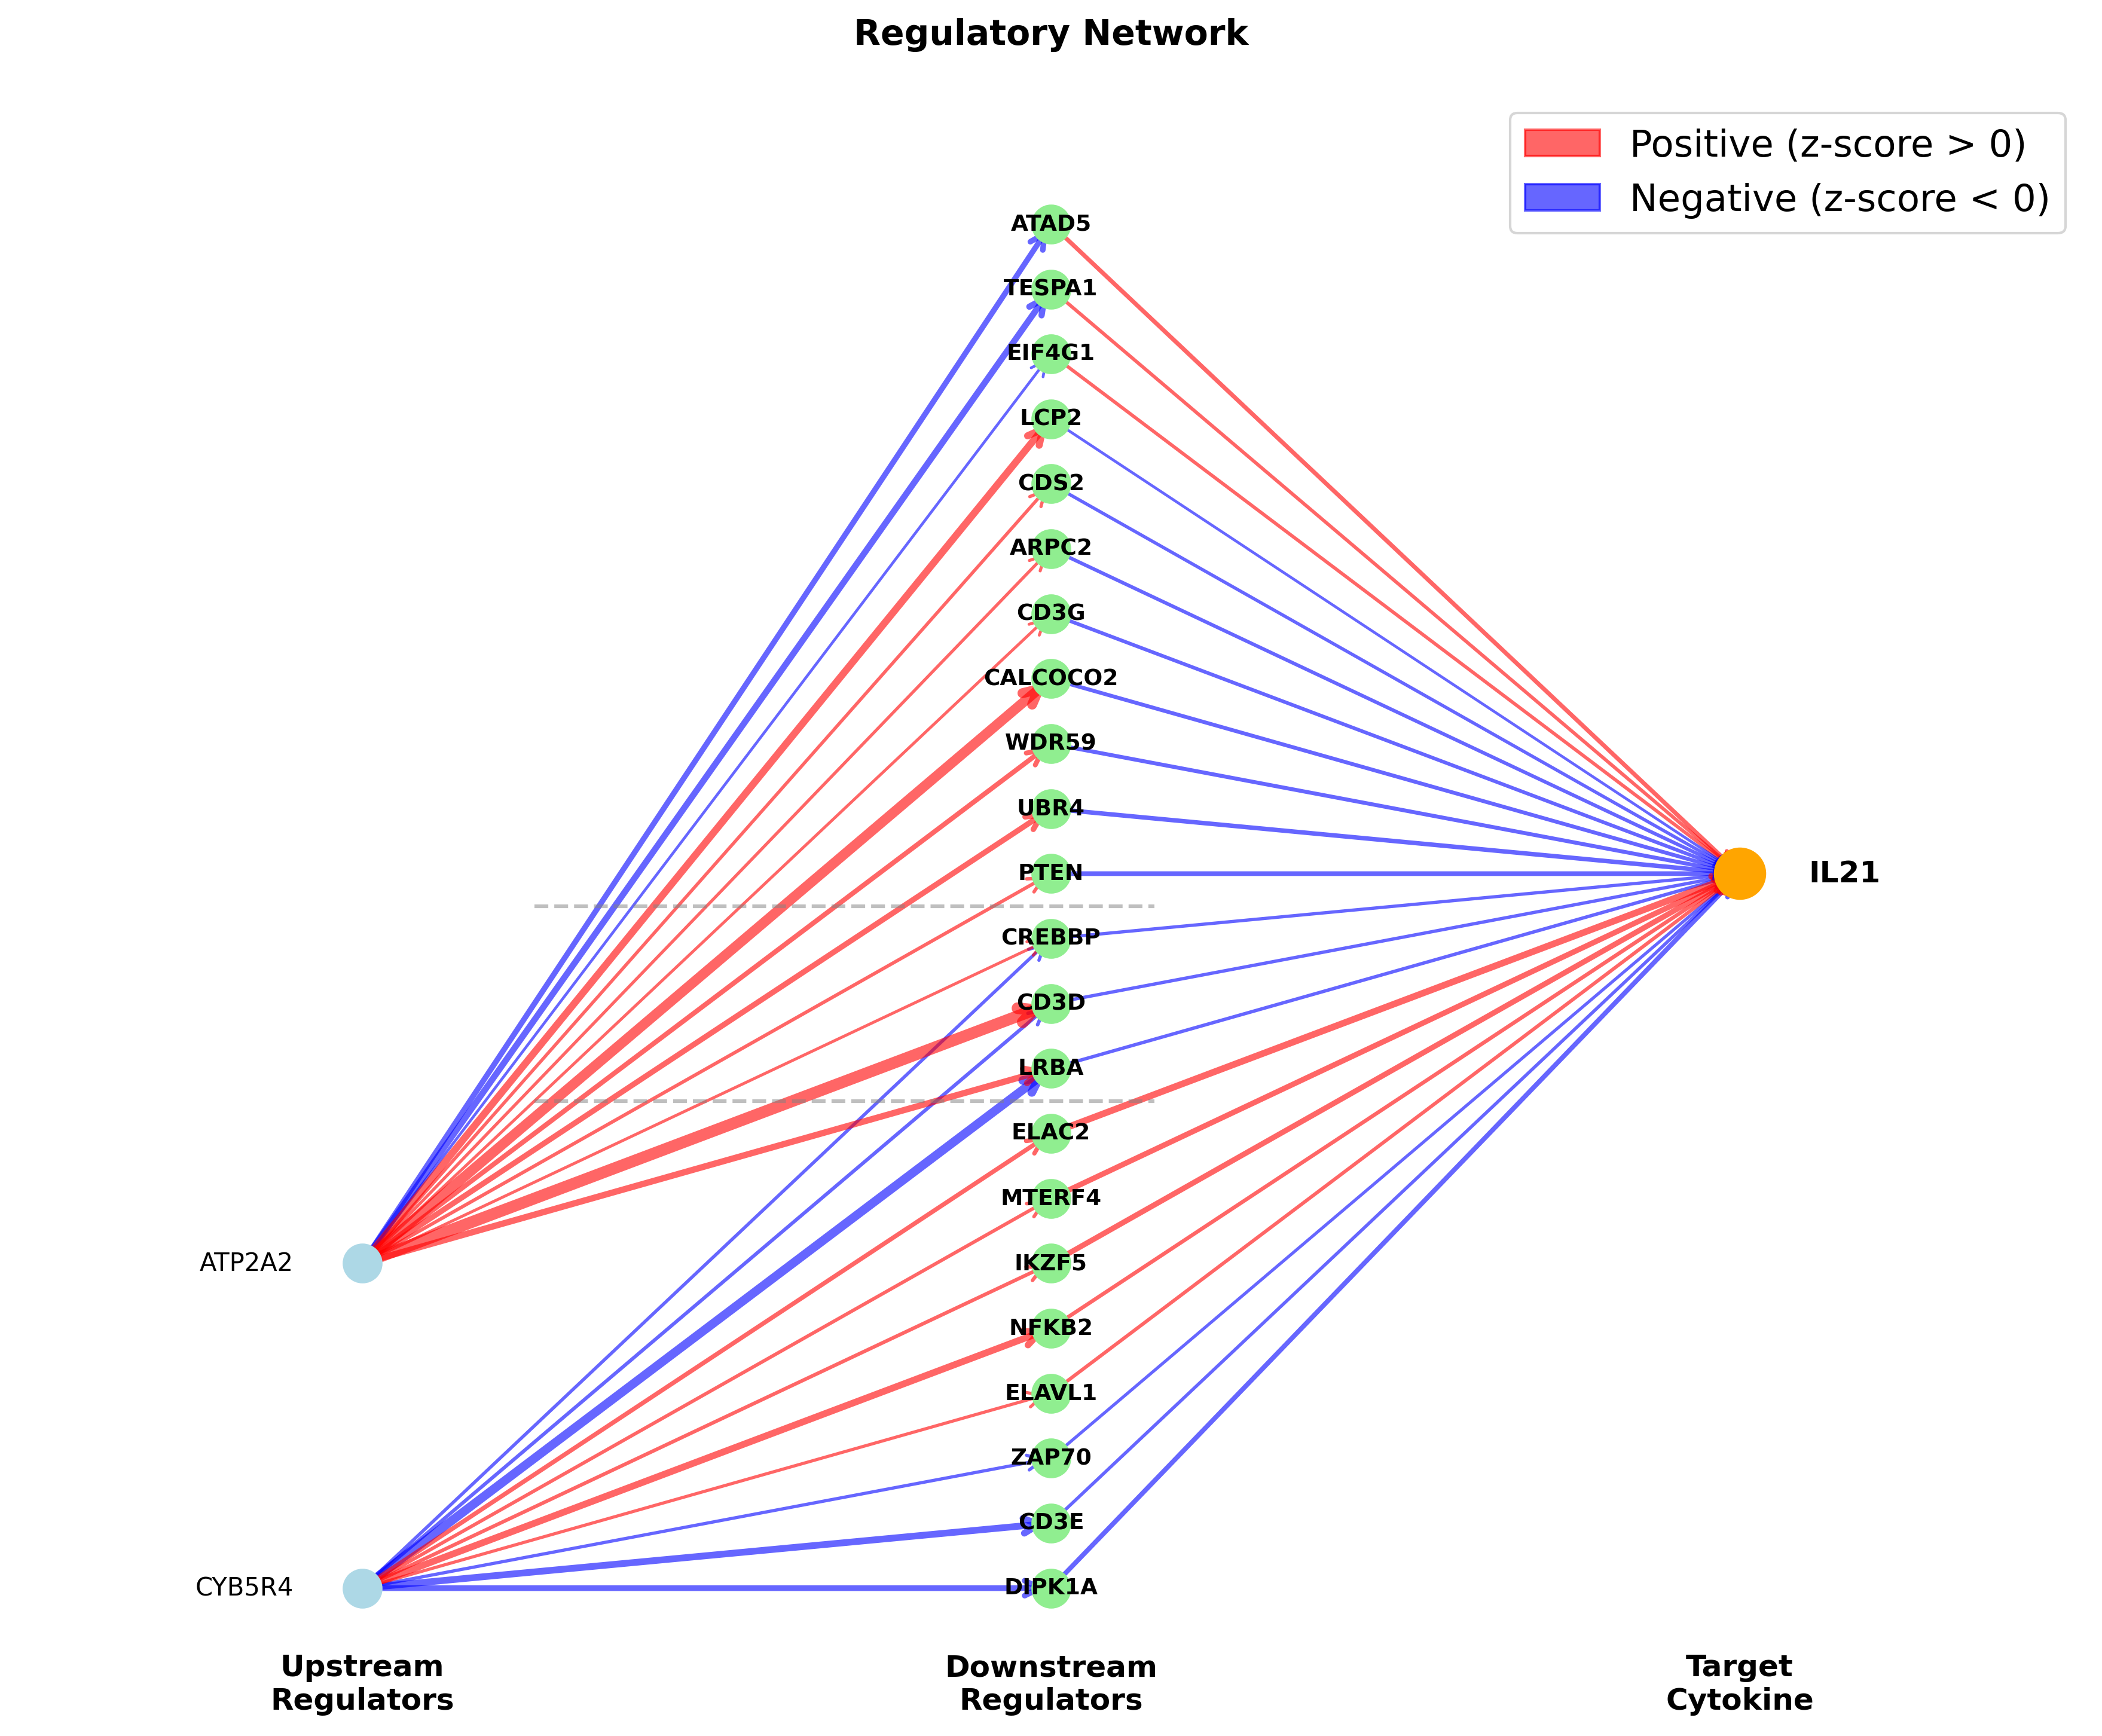

In [126]:

# Data from the table
data = network_df[(network_df['sign_coherent']) & (network_df['zscore_downreg'].abs() > 2)].copy()
# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Get unique values
upstream = data['upstream_regulators'].unique()

# Group downstream regulators by which upstream regulators affect them
downstream_groups = data.groupby('downstream_regulators')['upstream_regulators'].apply(set).reset_index()
downstream_groups.columns = ['downstream_regulators', 'upstream_set']

# Create a sorting key: 1 = CYB5R4 only, 2 = both, 3 = ATP2A2 only
def get_group(upstream_set):
    if upstream_set == {'CYB5R4'}:
        return 1
    elif upstream_set == {'ATP2A2'}:
        return 3
    else:
        return 2

downstream_groups['group'] = downstream_groups['upstream_set'].apply(get_group)

# Merge with cytokine zscores
downstream_with_cytokine = data[['downstream_regulators', 'zscore_cytokine']].drop_duplicates()
downstream_groups = downstream_groups.merge(downstream_with_cytokine, on='downstream_regulators')

# Sort by group first, then by zscore_cytokine
downstream_groups = downstream_groups.sort_values(['group', 'zscore_cytokine'])
downstream = downstream_groups['downstream_regulators'].values

cytokine = data['target_cytokine'].unique()[0]

# Position nodes in 3 columns
x_positions = [0, 1, 2]
# Space out upstream regulators more
y_upstream = {reg: i * 5 for i, reg in enumerate(upstream)}
y_downstream = {reg: i for i, reg in enumerate(downstream)}

# Draw nodes
for reg, y in y_upstream.items():
    ax.plot(x_positions[0], y, 'o', markersize=15, color='lightblue')
    ax.text(x_positions[0] - 0.1, y, reg, ha='right', va='center', fontsize=10)

# Draw downstream nodes with group separators
prev_group = None
for i, reg in enumerate(downstream):
    y = y_downstream[reg]
    
    # Determine current group
    upstream_set = set(data[data['downstream_regulators']==reg]['upstream_regulators'])
    if upstream_set == {'CYB5R4'}:
        current_group = 1
        group_label = 'CYB5R4 only'
    elif upstream_set == {'ATP2A2'}:
        current_group = 3
        group_label = 'ATP2A2 only'
    else:
        current_group = 2
        group_label = 'Both'
    
    # Draw separator line between groups
    if prev_group is not None and current_group != prev_group:
        ax.axhline(y - 0.5, color='gray', linestyle='--', alpha=0.5, xmin=0.25, xmax=0.55)
        
    ax.plot(x_positions[1], y, 'o', markersize=15, color='lightgreen')
    ax.text(x_positions[1], y, reg, ha='center', va='center', fontsize=9, weight='bold')
    
    prev_group = current_group

ax.plot(x_positions[2], len(downstream)//2, 'o', markersize=20, color='orange')
ax.text(x_positions[2] + 0.1, len(downstream)//2, cytokine, ha='left', va='center', fontsize=12, weight='bold')

# Draw arrows
drawn_downstream = set()
for _, row in data.iterrows():
    # Upstream to downstream
    x1, y1 = x_positions[0], y_upstream[row['upstream_regulators']]
    x2, y2 = x_positions[1], y_downstream[row['downstream_regulators']]
    color = 'blue' if row['zscore_downreg'] < 0 else 'red'
    linewidth = abs(row['zscore_downreg']) * 0.5  # Scale thickness by zscore
    arrow = mpatches.FancyArrowPatch((x1, y1), (x2, y2), 
                                     arrowstyle='->', mutation_scale=15,
                                     color=color, alpha=0.6, linewidth=linewidth)
    ax.add_patch(arrow)
    
    # Downstream to cytokine (only draw once per downstream regulator)
    if row['downstream_regulators'] not in drawn_downstream:
        x1, y1 = x_positions[1], y_downstream[row['downstream_regulators']]
        x2, y2 = x_positions[2], len(downstream)//2
        color = 'blue' if row['zscore_cytokine'] < 0 else 'red'
        linewidth = abs(row['zscore_cytokine']) * 0.5  # Scale thickness by zscore
        arrow = mpatches.FancyArrowPatch((x1, y1), (x2, y2),
                                         arrowstyle='->', mutation_scale=15,
                                         color=color, alpha=0.6, linewidth=linewidth)
        ax.add_patch(arrow)
        drawn_downstream.add(row['downstream_regulators'])

# Set labels
ax.text(x_positions[0], -1, 'Upstream\nRegulators', ha='center', va='top', fontsize=12, weight='bold')
ax.text(x_positions[1], -1, 'Downstream\nRegulators', ha='center', va='top', fontsize=12, weight='bold')
ax.text(x_positions[2], -1, 'Target\nCytokine', ha='center', va='top', fontsize=12, weight='bold')

# Format plot
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-2, max(len(upstream), len(downstream)) + 1)
ax.axis('off')
ax.set_title('Regulatory Network', fontsize=14, weight='bold', pad=20)

# Add legend
red_patch = mpatches.Patch(color='red', label='Positive (z-score > 0)', alpha=0.6)
blue_patch = mpatches.Patch(color='blue', label='Negative (z-score < 0)', alpha=0.6)
ax.legend(handles=[red_patch, blue_patch], loc='upper right')

plt.tight_layout()


In [ ]:
# Which genes regulate the upstream regulators?
regulators_cytokines_de_df = get_DE_results_long(adata_de, genes = upstream_regulators)
regulators_cytokines_de_df = regulators_cytokines_de_df[regulators_cytokines_de_df.culture_condition == 'Stim8hr']
regulators_cytokines_de_df = regulators_cytokines_de_df[ regulators_cytokines_de_df['significant'] & (~regulators_cytokines_de_df.target_contrast_gene_name.isin(upstream_regulators))]
regulators_cytokines_de_df

index    gene    log_fc    zscore  adj_p_value  \
281    ENSG00000004961_Stim8hr  CYB5R4  0.321035  3.382347     0.013926   
1798   ENSG00000023287_Stim8hr  ATP2A2  0.237991  3.207243     0.033156   
1844   ENSG00000023734_Stim8hr  ATP2A2 -0.235237 -3.121037     0.027571   
2067   ENSG00000029363_Stim8hr  CYB5R4  0.212525  3.752503     0.024415   
2096   ENSG00000029993_Stim8hr  ATP2A2  0.189604  3.930488     0.049549   
...                        ...     ...       ...       ...          ...   
64155  ENSG00000213658_Stim8hr  CYB5R4  0.341329  4.759860     0.000010   
66270  ENSG00000254999_Stim8hr  ATP2A2  0.164552  2.857431     0.052087   
66965  ENSG00000269955_Stim8hr  CYB5R4  0.221060  3.705271     0.013047   
67120  ENSG00000273611_Stim8hr  ATP2A2 -0.368580 -2.674394     0.092397   
67356  ENSG00000276045_Stim8hr  ATP2A2  0.168878  2.513308     0.096918   

       significant gene_name culture_condition  target_contrast  \
281           True    CYB5R4           Stim8hr  ENSG00000004961   
1798          True    ATP2A2           Stim8hr  ENSG00000023287   
1844          True    ATP2A2           Stim8hr  ENSG00000023734   
2067          True    CYB5R4           Stim8hr  ENSG00000029363   
2096          True    ATP2A2           Stim8hr  ENSG00000029993   
...            ...       ...               ...              ...   
64155         True    CYB5R4           Stim8hr  ENSG00000213658   
66270         True    ATP2A2           Stim8hr  ENSG00000254999   
66965         True    CYB5R4           Stim8hr  ENSG00000269955   
67120         True    ATP2A2           Stim8hr  ENSG00000273611   
67356         True    ATP2A2           Stim8hr  ENSG00000276045   

      target_contrast_gene_name  
281                        HCCS  
1798                     RB1CC1  
1844                      STRAP  
2067                     BCLAF1  
2096                      HMGB3  
...                         ...  
64155                       LAT  
66270                      BRK1  
66965               FMC1-LUC7L2  
67120                    ZNHIT3  
67356                     ORAI1  

[208 rows x 10 columns]